# Omya EDA from SQL queries

In [1]:
import pandas as pd
import numpy as np

# solo si se usa query para extraer tablas
# import mysql.connector
# from modules.mysql_funct import *
# database = "omya_ddbb"

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option("display.max_columns", None)

## Import data from SQL server
Queries built in MySQL Workbench

In [2]:
# # imports general numeric data from sql
# q_numdata = open(pth + "omya/scripts/omya_num_data.txt", "r").read()
# 
# data, column_names = select_from_table(query     = q_numdata,
#                                        database  = database,
#                                        password  = password,
#                                        host      = host,
#                                        user      = user)
# 
# sql_numdata = pd.DataFrame(data, columns=column_names)
# 
# # converts null/None to np.nan missing values
# sql_numdata.replace([None], [np.nan], inplace=True)
# 
# sql_numdata.to_csv(pth + "omya/sources/sql_numdata.csv", index=False)

#sql_numdata.head(5)

In [3]:
# # imports only categorical data from sql
# q_prod_to_cust = open(pth + "omya/scripts/omya_cat_data.txt", "r").read()
# 
# data, column_names = select_from_table(query     = q_prod_to_cust,
#                                        database  = database,
#                                        password  = password,
#                                        host      = host,
#                                        user      = user)
# 
# sql_p_cust = pd.DataFrame(data, columns=column_names)
# 
# sql_p_cust.to_csv(pth + "omya/sources/sql_p_cust.csv", index=False)

#sql_p_cust.head(5)

In [ ]:
# imports from csv
sql_numdata = pd.read_csv("omya/sources/sql_numdata.csv")
# imports from csv
sql_p_cust = pd.read_csv("omya/sources/sql_p_cust.csv")

## Imported data info

In [4]:
# change month values to str
sql_numdata['month_'] = sql_numdata['month_'].astype(int)
sql_numdata.sort_values(['month_'], ascending=True, inplace=True)
month_d = ['jan','feb','mar','apr','may','jun','jul','ago','sep','oct','nov','dic']
month_v = [i+1 for i in range(12)]
sql_numdata.sort_values(['month_'], ascending=False)
for k, v in zip(month_d, month_v):
    sql_numdata['month_'].replace(v, k, inplace=True)

# modifies country value for sorting
country_d = [f"Country_0{i}" for i in range(1,10)]
country_v = [f"Country_{i}" for i in range(1,10)]
for k, v in zip(country_d, country_v):
    sql_numdata['country'].replace(v, k, inplace=True)

# cast columns dtypes
for col in sql_numdata.iloc[:,9:13].columns:
    sql_numdata[col] = sql_numdata[col].astype(int)
for col in sql_numdata.iloc[:,13:].columns:
    sql_numdata[col] = sql_numdata[col].astype(float)

**Observaciones**
* no hay patrones claros de estacionareidad
    - revisar relacion entre relaciones y mkt_pos con las ventas y caracteristicas de mercancias (window, brand...)
* para el caso de relationship y mkt_pos: los datos numericos son duplicados y causan problemas en la lectura
    - crear 2 columnas: relationship_score, mkt_pos_score
    - asignar calificacion sugerida (1 a 5) y promediar para obtener score
* las columnas **score** se usaran para modelo de clustering

*Datos numericos duplicados segun mascara de columna*
* relatioship
* 'market_position'

***UNA* KEY ACCOUNT(empresa) *TIENE VARIOS* CUSTOMERS(lineas de credito, pueden ser UN, sucursales, etc de la misma empresa)**

### Relationship and market position scores
Create scores columns from Customers data: relationship and market position

In [5]:
# importante mantener la cantidad de customers en el proceso de creacion de scores (unique customers = 926)
df_k_r_mkt = sql_numdata[["customer", "market_position", "relationship"]].copy().sort_values(["customer"], ascending=True)

# descripcion de scores
l_mkt_desc = [list(i for i in df_k_r_mkt[df_k_r_mkt['customer']== row ]['market_position'].unique()) for row in df_k_r_mkt['customer'].unique()]
l_rel_desc = [list(i for i in df_k_r_mkt[df_k_r_mkt['customer']== row ]['relationship'].unique()) for row in df_k_r_mkt['customer'].unique()]

# lista de etiquetas y clasificador
score_list = [i for i in range(1,6)]
mkt_tag = ['Niche Player', 'Market Follower', 'Faster Growing than Market', 'Innovative', 'Innovative & Faster Growing than Market']
rel_tag = ['Opportunistic', 'Transactional', 'Pure Business', 'Advanced Business Ties', 'Partnership']

# agrega 2 columnas
df_k_r_mkt['mkt_score'] = df_k_r_mkt['market_position'].copy()
df_k_r_mkt['rel_score'] = df_k_r_mkt['relationship'].copy()

# reemplaza valores
for k, v in zip(score_list, mkt_tag):
    df_k_r_mkt['mkt_score'] = df_k_r_mkt['mkt_score'].replace(v, k)
for k, v in zip(score_list, rel_tag):
    df_k_r_mkt['rel_score'] = df_k_r_mkt['rel_score'].replace(v, k)

# promedia las calificaciones por customer con groupby
customer_group_scores = df_k_r_mkt[['customer', 'mkt_score', 'rel_score']].groupby('customer').mean().round(1)
# extraer los promedios sin multi-index
customer_scores = pd.DataFrame(
    {'customer'              : [i for i in customer_group_scores.index],
     'market_position_score' : [i for i in customer_group_scores['mkt_score'].values],
     'relationship_score'    : [i for i in customer_group_scores['rel_score'].values],
     'market_position_desc'  : [', '.join(l_mkt_desc[i]) for i in range(len(l_mkt_desc))],
     'relationship_desc'     : [', '.join(l_rel_desc[i]) for i in range(len(l_rel_desc))]
     })
#customer_scores.head()

Drop relationship and market_position cols to drop duplicates in df_numdata and df_p_cust

In [6]:
# elimina columnas que duplican los demas datos en df nuevos
df_numdata = sql_numdata.copy().drop(['relationship', 'market_position'], axis=1)
df_p_cust = sql_p_cust.copy().drop(['relationship', 'market_position'], axis=1)

# elimina datos duplicados
df_numdata.drop_duplicates(inplace=True)
df_p_cust.drop_duplicates(inplace=True)

# reinicia indices
df_numdata.reset_index(drop=True, inplace=True)
df_p_cust.reset_index(drop=True, inplace=True)

# df_numdata.columns, df_p_cust.columns 

## Volume importance (qty) and Sales (net sales) scores

In [7]:
# funcion para crear las columnas de scores en df_numdata
def score_col(df, list_ref_values, col_values, score_col_name):
    """
    Es una funcion dependiente de pandas y numpy para crear una columna de calificaciones de 1 a 5 relacionada a
    umbrales de distribucion. Esta pensado para quintiles, se pueden calcular con np.percentile() o con
    df.describe(percentiles = [.2,.4,.6,.8]).T (No califica valores en 0).
    
    Parametros
    --------------
    df = pd.DataFrame()
    list_ref_values = lista: columna de referencia de percentiles, para comparacion y calificacion entre 1 y 5
    col_values = pd.Serie(), columna de referencia, se duplica para crear la nueva columna y se comparan los valores, manteniendo la integridad de los datos
    score_col_name = str, lista: nombre de la nueva columna que contendra las calificaciones
    
    Input
    --------------
    DataFrame con datos numericos categóricos
    
    Output
    --------------
    DataFrame con una columna nueva categorica de valores numericos
    """
    df[score_col_name] = df[col_values].copy()
    for v in df[col_values].values:
        if v < list_ref_values[0] and v > 0:
            df[score_col_name].replace(to_replace = v, value = 1, inplace=True)
        if v >= list_ref_values[0] and v < list_ref_values[1]:
            df[score_col_name].replace(to_replace = v, value = 2, inplace=True)
        if v >= list_ref_values[1] and v < list_ref_values[2]:
            df[score_col_name].replace(to_replace = v, value = 3, inplace=True)
        if v >= list_ref_values[2] and v < list_ref_values[3]:
            df[score_col_name].replace(to_replace = v, value = 4, inplace=True)
        if v >= list_ref_values[3]:
            df[score_col_name].replace(to_replace = v, value = 5, inplace=True)
        else:
            df[score_col_name].replace(to_replace = v, value = np.nan, inplace=True)

    return df

# funcion para crear columnas que describen calificaciones del 1 al 5
def dscore_col(df, l_desc_scores, score_col, dscore_col_name):
    """
    Es una funcion dependiente de pandas y numpy para crear una columna descriptiva relacionada a valores numericos categoricos
    
    Parametros
    --------------
    df = pd.DataFrame()
    l_desc_scores = lista: debe tener mismo len() de 4. Cada uno de los valores de la lista se usara para reemplazar valores de la columna
    score_col = pd.Serie(), lista: columna de referencia de valores entre 1 y 5, puede contener np.nan, manteniendo al integridad de informacion
    dscore_col_name = str, lista: nombre de la nueva columna que contendra las descripciones de las calificaciones
    
    Input
    --------------
    DataFrame con datos numericos categóricos
    
    Output
    --------------
    DataFrame con una columna nueva categorica de valores str
    """
    df[dscore_col_name] = df[score_col].copy()
    for v in df[score_col].values:
        if v < 2 and v >= 1:
            df[dscore_col_name].replace(to_replace = v, value = l_desc_scores[0], inplace=True)
        if v < 3 and v >= 2:
            df[dscore_col_name].replace(to_replace = v, value = l_desc_scores[1], inplace=True)
        if v < 4 and v >= 3:
            df[dscore_col_name].replace(to_replace = v, value = l_desc_scores[2], inplace=True)
        if v < 5 and v >= 4:
            df[dscore_col_name].replace(to_replace = v, value = l_desc_scores[3], inplace=True)
        if v == 5:
            df[dscore_col_name].replace(to_replace = v, value = l_desc_scores[4], inplace=True)
        else:
            df[dscore_col_name].replace(to_replace = v, value = np.nan, inplace=True)

    return df

### Quantity, Sales, Margin (P2)

* Converts to anual data
* Score based on anual distributions
* Descriptive column from scores

In [8]:
# suma anual de datos numericos por cada customer
df_anual_gb_sum = df_numdata[['customer', 'sales_qty_2021', 'sales_qty_2022', 'sales_qty_2023', 'sales_qty_2024',
                            'net_sales_2021', 'net_sales_2022','net_sales_2023', 'net_sales_2024',
                            'p2_2021', 'p2_2022', 'p2_2023','p2_2024']].groupby('customer').sum()

# convierte groupby anterior en dataframe con indexado simple
df_anual_numdata = pd.DataFrame({
    'customer'      : [i for i in df_anual_gb_sum.index],
    'sales_qty_2021': [i for i in df_anual_gb_sum['sales_qty_2021'].values],
    'sales_qty_2022': [i for i in df_anual_gb_sum['sales_qty_2022'].values],
    'sales_qty_2023': [i for i in df_anual_gb_sum['sales_qty_2023'].values],
    'sales_qty_2024': [i for i in df_anual_gb_sum['sales_qty_2024'].values],
    'net_sales_2021': [i for i in df_anual_gb_sum['net_sales_2021'].values],
    'net_sales_2022': [i for i in df_anual_gb_sum['net_sales_2022'].values],
    'net_sales_2023': [i for i in df_anual_gb_sum['net_sales_2023'].values],
    'net_sales_2024': [i for i in df_anual_gb_sum['net_sales_2024'].values],
    'p2_2021'       : [i for i in df_anual_gb_sum['p2_2021'].values],
    'p2_2022'       : [i for i in df_anual_gb_sum['p2_2022'].values],
    'p2_2023'       : [i for i in df_anual_gb_sum['p2_2023'].values],
    'p2_2024'       : [i for i in df_anual_gb_sum['p2_2024'].values]
})

df_anual_numdata.head(3)

customer  sales_qty_2021  sales_qty_2022  sales_qty_2023  \
0  Customer_1005        28682071        32079526        31453752   
1  Customer_1011        26662722        26804515        28793437   
2  Customer_1023        18573979        25156206        26389512   

   sales_qty_2024  net_sales_2021  net_sales_2022  net_sales_2023  \
0        26429101    1.695876e+09    1.833924e+09    1.900422e+09   
1        24591574    1.362151e+09    1.531981e+09    1.890697e+09   
2        29153877    1.089888e+09    1.478579e+09    1.669236e+09   

   net_sales_2024       p2_2021       p2_2022       p2_2023       p2_2024  
0    1.595169e+09  9.462729e+08  8.847213e+08  1.072850e+09  7.123357e+08  
1    1.581387e+09  5.740576e+08  7.805375e+08  1.046884e+09  7.476680e+08  
2    1.651936e+09  5.051393e+08  8.404226e+08  6.137710e+08  8.069199e+08

In [9]:
# describe con percentiles .2, .4, .6, .8 de ventas anuales
df_qty_sales_dist = df_anual_numdata.describe(percentiles = [.2,.4,.6,.8]).T
df_qty_sales_dist

count          mean           std           min           20%  \
sales_qty_2021  926.0  3.095734e+07  9.199447e+06  1.649502e+07  2.520183e+07   
sales_qty_2022  926.0  3.089311e+07  9.409394e+06  1.618285e+07  2.506982e+07   
sales_qty_2023  926.0  3.094530e+07  9.238846e+06  1.582548e+07  2.521665e+07   
sales_qty_2024  926.0  3.085218e+07  9.523836e+06  1.489485e+07  2.500418e+07   
net_sales_2021  926.0  1.854242e+09  5.719174e+08  9.241874e+08  1.486471e+09   
net_sales_2022  926.0  1.856022e+09  5.747311e+08  7.797190e+08  1.478130e+09   
net_sales_2023  926.0  1.863496e+09  5.730807e+08  9.125515e+08  1.495487e+09   
net_sales_2024  926.0  1.851512e+09  5.880437e+08  9.254940e+08  1.484426e+09   
p2_2021         926.0  9.250513e+08  3.002378e+08  4.252840e+08  7.191565e+08   
p2_2022         926.0  9.279978e+08  3.012696e+08  3.570266e+08  7.094663e+08   
p2_2023         926.0  9.328639e+08  3.046792e+08  4.147253e+08  7.300287e+08   
p2_2024         926.0  9.304041e+08  3.069615e+08  3.595418e+08  7.124158e+08   

                         40%           50%           60%           80%  \
sales_qty_2021  2.779764e+07  2.894014e+07  3.029287e+07  3.336786e+07   
sales_qty_2022  2.755518e+07  2.887441e+07  3.024336e+07  3.337278e+07   
sales_qty_2023  2.769572e+07  2.888427e+07  3.021416e+07  3.330176e+07   
sales_qty_2024  2.755105e+07  2.877567e+07  2.997062e+07  3.329221e+07   
net_sales_2021  1.652563e+09  1.730488e+09  1.826738e+09  2.058595e+09   
net_sales_2022  1.649163e+09  1.738616e+09  1.823441e+09  2.066903e+09   
net_sales_2023  1.664461e+09  1.747494e+09  1.826660e+09  2.048330e+09   
net_sales_2024  1.653044e+09  1.728791e+09  1.800199e+09  2.025639e+09   
p2_2021         8.207018e+08  8.645672e+08  9.119274e+08  1.048535e+09   
p2_2022         8.255310e+08  8.708412e+08  9.237263e+08  1.052813e+09   
p2_2023         8.203267e+08  8.674209e+08  9.209001e+08  1.060001e+09   
p2_2024         8.215834e+08  8.738072e+08  9.205252e+08  1.060108e+09   

                         max  
sales_qty_2021  9.352017e+07  
sales_qty_2022  9.733723e+07  
sales_qty_2023  8.489478e+07  
sales_qty_2024  8.994786e+07  
net_sales_2021  5.853236e+09  
net_sales_2022  5.647977e+09  
net_sales_2023  5.150225e+09  
net_sales_2024  5.426189e+09  
p2_2021         2.958512e+09  
p2_2022         3.017132e+09  
p2_2023         2.719545e+09  
p2_2024         2.525893e+09

In [10]:
# montos anuales y calificaciones de distribucion de ventas y margenes de ganancia

col_dist_list = ['sales_qty_2021' ,'sales_qty_2022' ,'sales_qty_2023' ,'sales_qty_2024' ,'net_sales_2021' ,'net_sales_2022' ,'net_sales_2023' ,'net_sales_2024','p2_2021', 'p2_2022', 'p2_2023', 'p2_2024']
col_score_list = ['qty_2021_score' ,'qty_2022_score' ,'qty_2023_score' ,'qty_2024_score' ,'sales_2021_score' ,'sales_2022_score' ,'sales_2023_score' ,'sales_2024_score', 'p2_2021_score', 'p2_2022_score', 'p2_2023_score', 'p2_2024_score']

for i in range(len(col_dist_list)):
    score_col(df = df_anual_numdata,
              list_ref_values = [i for i in df_qty_sales_dist.loc[col_dist_list[i], ['20%','40%','60%','80%']].values.astype(int)],
              col_values= col_dist_list[i],
              score_col_name = col_score_list[i])

df_anual_numdata.head(2)

customer  sales_qty_2021  sales_qty_2022  sales_qty_2023  \
0  Customer_1005        28682071        32079526        31453752   
1  Customer_1011        26662722        26804515        28793437   

   sales_qty_2024  net_sales_2021  net_sales_2022  net_sales_2023  \
0        26429101    1.695876e+09    1.833924e+09    1.900422e+09   
1        24591574    1.362151e+09    1.531981e+09    1.890697e+09   

   net_sales_2024       p2_2021       p2_2022       p2_2023       p2_2024  \
0    1.595169e+09  9.462729e+08  8.847213e+08  1.072850e+09  7.123357e+08   
1    1.581387e+09  5.740576e+08  7.805375e+08  1.046884e+09  7.476680e+08   

   qty_2021_score  qty_2022_score  qty_2023_score  qty_2024_score  \
0               3               4               4               2   
1               2               2               3               1   

   sales_2021_score  sales_2022_score  sales_2023_score  sales_2024_score  \
0               3.0               4.0               4.0               2.0   
1               1.0               2.0               4.0               2.0   

   p2_2021_score  p2_2022_score  p2_2023_score  p2_2024_score  
0            4.0            3.0            5.0            1.0  
1            1.0            2.0            4.0            2.0

In [11]:
# tags distribucion volumen y ventas anuales por customer
tag_dist_list = ['Neglectable', 'Low', 'Medium', 'High', 'Strategic']
dist_dscores_col = ['qty_2021_score_desc', 'qty_2022_score_desc', 'qty_2023_score_desc', 'qty_2024_score_desc',
                    'sales_2021_score_desc', 'sales_2022_score_desc', 'sales_2023_score_desc','sales_2024_score_desc',
                    'p2_2021_score_desc', 'p2_2022_score_desc', 'p2_2023_score_desc','p2_2024_score_desc']

for i in range(len(col_score_list)):
    dscore_col(df = df_anual_numdata,
               l_desc_scores = tag_dist_list,
               score_col = col_score_list[i],
               dscore_col_name = dist_dscores_col[i])
    
df_anual_numdata.head(2)

customer  sales_qty_2021  sales_qty_2022  sales_qty_2023  \
0  Customer_1005        28682071        32079526        31453752   
1  Customer_1011        26662722        26804515        28793437   

   sales_qty_2024  net_sales_2021  net_sales_2022  net_sales_2023  \
0        26429101    1.695876e+09    1.833924e+09    1.900422e+09   
1        24591574    1.362151e+09    1.531981e+09    1.890697e+09   

   net_sales_2024       p2_2021       p2_2022       p2_2023       p2_2024  \
0    1.595169e+09  9.462729e+08  8.847213e+08  1.072850e+09  7.123357e+08   
1    1.581387e+09  5.740576e+08  7.805375e+08  1.046884e+09  7.476680e+08   

   qty_2021_score  qty_2022_score  qty_2023_score  qty_2024_score  \
0               3               4               4               2   
1               2               2               3               1   

   sales_2021_score  sales_2022_score  sales_2023_score  sales_2024_score  \
0               3.0               4.0               4.0               2.0   
1               1.0               2.0               4.0               2.0   

   p2_2021_score  p2_2022_score  p2_2023_score  p2_2024_score  \
0            4.0            3.0            5.0            1.0   
1            1.0            2.0            4.0            2.0   

  qty_2021_score_desc qty_2022_score_desc qty_2023_score_desc  \
0              Medium                High                High   
1                 Low                 Low              Medium   

  qty_2024_score_desc sales_2021_score_desc sales_2022_score_desc  \
0                 Low                Medium                  High   
1         Neglectable           Neglectable                   Low   

  sales_2023_score_desc sales_2024_score_desc p2_2021_score_desc  \
0                  High                   Low               High   
1                  High                   Low        Neglectable   

  p2_2022_score_desc p2_2023_score_desc p2_2024_score_desc  
0             Medium          Strategic        Neglectable  
1                Low               High                Low

### Portfolio anual data

* Merges row descriptive values in one row to avoid duplicates
* Counts unique descriptive values
* Score based on descriptive quantities

In [12]:
# portfolio descriptive columns
df_prod_portfolio = pd.DataFrame(df_p_cust['customer'].copy().unique(), columns=['customer'])
df_prod_portfolio['material_portfolio'] = [len(list(i for i in df_p_cust[df_p_cust['customer']== row ]['material'].unique())) for row in df_p_cust['customer'].unique()]
df_prod_portfolio['material_portfolio_desc'] = [", ".join(list(i for i in df_p_cust[df_p_cust['customer']== row ]['material'].unique())) for row in df_p_cust['customer'].unique()]
df_prod_portfolio['brand_portfolio'] = [len(list(i for i in df_p_cust[df_p_cust['customer']== row ]['brand'].unique())) for row in df_p_cust['customer'].unique()]
df_prod_portfolio['brand_portfolio_desc'] = [", ".join(list(i for i in df_p_cust[df_p_cust['customer']== row ]['brand'].unique())) for row in df_p_cust['customer'].unique()]
df_prod_portfolio['product_type_portfolio'] = [len(list(i for i in df_p_cust[df_p_cust['customer']== row ]['product_type'].unique())) for row in df_p_cust['customer'].unique()]
df_prod_portfolio['product_type_portfolio_desc'] = [", ".join(list(i for i in df_p_cust[df_p_cust['customer']== row ]['product_type'].unique())) for row in df_p_cust['customer'].unique()]

# df_prod_portfolio.head(2)

In [13]:
# portfolio scores en df de productos y materiales
portf_col_values = ['material_portfolio', 'brand_portfolio', 'product_type_portfolio']
portf_scores_col = ['material_portfolio_score', 'brand_portfolio_score', 'product_type_portfolio_score']

# define cantidades por cada score
for idx_col in range(len(portf_col_values)):
    df_prod_portfolio[portf_scores_col[idx_col]] = df_prod_portfolio[portf_col_values[idx_col]].copy()
    df_prod_portfolio[portf_scores_col[idx_col]].replace(to_replace = [1,2], value = 1, inplace=True)
    df_prod_portfolio[portf_scores_col[idx_col]].replace(to_replace = [3,4], value = 2, inplace=True)
    df_prod_portfolio[portf_scores_col[idx_col]].replace(to_replace = [5,6], value = 3, inplace=True)
    df_prod_portfolio[portf_scores_col[idx_col]].replace(to_replace = [7,8], value = 4, inplace=True)
    df_prod_portfolio[portf_scores_col[idx_col]].replace(to_replace = [9,10,11,12], value = 5, inplace=True)

# df_prod_portfolio[['customer','material_portfolio', 'brand_portfolio', 'product_type_portfolio', 'material_portfolio_score', 'brand_portfolio_score', 'product_type_portfolio_score']].head(5)

In [14]:
# portafolio descriptive columns
tag_portf_list = ['A couple or one', 'Several', 'A few', 'Many', 'Extended range']
portf_dscores_col = ['material_portfolio_score_desc', 'brand_portfolio_score_desc', 'product_type_portfolio_score_desc']

for i in range(len(portf_scores_col)):
    dscore_col(df = df_prod_portfolio,
               l_desc_scores = tag_portf_list,
               score_col = portf_scores_col[i],
               dscore_col_name = portf_dscores_col[i])
df_prod_portfolio.head(2)

customer  material_portfolio  \
0  Customer_5922                   8   
1  Customer_6726                   4   

                             material_portfolio_desc  brand_portfolio  \
0  MAT001622, MAT001837, MAT002764, MAT000748, MA...                8   
1         MAT000093, MAT002850, MAT001846, MAT002542                4   

                                brand_portfolio_desc  product_type_portfolio  \
0  Brand_353, Brand_1462, Brand_3849, Brand_3955,...                       8   
1     Brand_6858, Brand_2435, Brand_5359, Brand_1198                       4   

                         product_type_portfolio_desc  \
0  Product_Type_321, Product_Type_1462, Product_T...   
1  Product_Type_831, Product_Type_496, Product_Ty...   

   material_portfolio_score  brand_portfolio_score  \
0                         4                      4   
1                         2                      2   

   product_type_portfolio_score material_portfolio_score_desc  \
0                             4                          Many   
1                             2                       Several   

  brand_portfolio_score_desc product_type_portfolio_score_desc  
0                       Many                              Many  
1                    Several                           Several

### Feature_tag scores

In [15]:
# cuenta feature tags en columnas
df_prod_portfolio['feature_tag_null'] = [df_numdata[df_numdata['customer']== row].value_counts('window_tag').at['Null'] for row in df_p_cust['customer'].unique()]
df_prod_portfolio['feature_tag_q1'] = [df_numdata[df_numdata['customer']== row].value_counts('window_tag').at['WindowQ1'] for row in df_p_cust['customer'].unique()]
df_prod_portfolio['feature_tag_q2'] = [df_numdata[df_numdata['customer']== row].value_counts('window_tag').at['WindowQ2'] for row in df_p_cust['customer'].unique()]
df_prod_portfolio['feature_tag_q3'] = [df_numdata[df_numdata['customer']== row].value_counts('window_tag').at['WindowQ3'] for row in df_p_cust['customer'].unique()]
df_prod_portfolio['feature_tag_q4'] = [df_numdata[df_numdata['customer']== row].value_counts('window_tag').at['WindowQ4'] for row in df_p_cust['customer'].unique()]

df_prod_portfolio.head(3)

customer  material_portfolio  \
0  Customer_5922                   8   
1  Customer_6726                   4   
2  Customer_7395                   4   

                             material_portfolio_desc  brand_portfolio  \
0  MAT001622, MAT001837, MAT002764, MAT000748, MA...                8   
1         MAT000093, MAT002850, MAT001846, MAT002542                4   
2         MAT002425, MAT001613, MAT000368, MAT001521                4   

                                brand_portfolio_desc  product_type_portfolio  \
0  Brand_353, Brand_1462, Brand_3849, Brand_3955,...                       8   
1     Brand_6858, Brand_2435, Brand_5359, Brand_1198                       4   
2     Brand_7682, Brand_5778, Brand_4693, Brand_3998                       4   

                         product_type_portfolio_desc  \
0  Product_Type_321, Product_Type_1462, Product_T...   
1  Product_Type_831, Product_Type_496, Product_Ty...   
2  Product_Type_1464, Product_Type_1126, Product_...   

   material_portfolio_score  brand_portfolio_score  \
0                         4                      4   
1                         2                      2   
2                         2                      2   

   product_type_portfolio_score material_portfolio_score_desc  \
0                             4                          Many   
1                             2                       Several   
2                             2                       Several   

  brand_portfolio_score_desc product_type_portfolio_score_desc  \
0                       Many                              Many   
1                    Several                           Several   
2                    Several                           Several   

   feature_tag_null  feature_tag_q1  feature_tag_q2  feature_tag_q3  \
0               103              23              23              33   
1                50              12              18              16   
2                51              14               9              17   

   feature_tag_q4  
0              27  
1              12  
2              14

In [16]:
# se calificara en base a distribucion
ftag_dist = df_prod_portfolio[['customer', 'feature_tag_null', 'feature_tag_q1', 'feature_tag_q2', 'feature_tag_q3','feature_tag_q4']].describe(percentiles=[.2,.4,.6,.8]).T
ftag_dist

count       mean        std   min   20%   40%   50%   60%  \
feature_tag_null  926.0  53.914687  15.781147  29.0  44.0  49.0  51.0  53.0   
feature_tag_q1    926.0  13.441685   4.912901   4.0  10.0  12.0  13.0  14.0   
feature_tag_q2    926.0  13.681425   5.115849   3.0  10.0  12.0  13.0  14.0   
feature_tag_q3    926.0  13.518359   5.173653   4.0  10.0  12.0  13.0  14.0   
feature_tag_q4    926.0  13.435205   4.929735   3.0  10.0  12.0  13.0  14.0   

                   80%    max  
feature_tag_null  58.0  162.0  
feature_tag_q1    16.0   39.0  
feature_tag_q2    17.0   52.0  
feature_tag_q3    16.0   40.0  
feature_tag_q4    16.0   38.0

In [17]:
# columnas de feature_tag scores
ftag_cols = ['feature_tag_null', 'feature_tag_q1', 'feature_tag_q2', 'feature_tag_q3','feature_tag_q4']
ftag_scores_col = ['feature_tag_null_score', 'feature_tag_q1_score', 'feature_tag_q2_score', 'feature_tag_q3_score', 'feature_tag_q4_score']

for i in range(len(ftag_cols)):
    score_col(df = df_prod_portfolio,
              list_ref_values = [i for i in ftag_dist.loc[ftag_cols[i], ['20%','40%','60%','80%']].values.astype(int)],
              col_values = ftag_cols[i],
              score_col_name = ftag_scores_col[i])
df_prod_portfolio.head(2)

customer  material_portfolio  \
0  Customer_5922                   8   
1  Customer_6726                   4   

                             material_portfolio_desc  brand_portfolio  \
0  MAT001622, MAT001837, MAT002764, MAT000748, MA...                8   
1         MAT000093, MAT002850, MAT001846, MAT002542                4   

                                brand_portfolio_desc  product_type_portfolio  \
0  Brand_353, Brand_1462, Brand_3849, Brand_3955,...                       8   
1     Brand_6858, Brand_2435, Brand_5359, Brand_1198                       4   

                         product_type_portfolio_desc  \
0  Product_Type_321, Product_Type_1462, Product_T...   
1  Product_Type_831, Product_Type_496, Product_Ty...   

   material_portfolio_score  brand_portfolio_score  \
0                         4                      4   
1                         2                      2   

   product_type_portfolio_score material_portfolio_score_desc  \
0                             4                          Many   
1                             2                       Several   

  brand_portfolio_score_desc product_type_portfolio_score_desc  \
0                       Many                              Many   
1                    Several                           Several   

   feature_tag_null  feature_tag_q1  feature_tag_q2  feature_tag_q3  \
0               103              23              23              33   
1                50              12              18              16   

   feature_tag_q4  feature_tag_null_score  feature_tag_q1_score  \
0              27                       5                     1   
1              12                       3                     3   

   feature_tag_q2_score  feature_tag_q3_score  feature_tag_q4_score  
0                     1                     1                     1  
1                     1                     1                     1

### Merge selected data

In [18]:
# df_anual_numdata.columns, customer_scores.columns, df_prod_portfolio.columns

In [19]:
# merges new score and descriptive columns into a new dataframe for model select_dataing
df_select_data = pd.merge(df_anual_numdata, customer_scores, how = 'inner', on = 'customer')
df_select_data = pd.merge(df_select_data, df_prod_portfolio, how = 'inner', on = 'customer')

df_select_data.sort_values('customer', ascending=True, inplace=True)
df_select_data.reset_index(drop=True, inplace=True)

df_select_data.head(3)

customer  sales_qty_2021  sales_qty_2022  sales_qty_2023  \
0  Customer_1005        28682071        32079526        31453752   
1  Customer_1011        26662722        26804515        28793437   
2  Customer_1023        18573979        25156206        26389512   

   sales_qty_2024  net_sales_2021  net_sales_2022  net_sales_2023  \
0        26429101    1.695876e+09    1.833924e+09    1.900422e+09   
1        24591574    1.362151e+09    1.531981e+09    1.890697e+09   
2        29153877    1.089888e+09    1.478579e+09    1.669236e+09   

   net_sales_2024       p2_2021       p2_2022       p2_2023       p2_2024  \
0    1.595169e+09  9.462729e+08  8.847213e+08  1.072850e+09  7.123357e+08   
1    1.581387e+09  5.740576e+08  7.805375e+08  1.046884e+09  7.476680e+08   
2    1.651936e+09  5.051393e+08  8.404226e+08  6.137710e+08  8.069199e+08   

   qty_2021_score  qty_2022_score  qty_2023_score  qty_2024_score  \
0               3               4               4               2   
1               2               2               3               1   
2               1               2               2               3   

   sales_2021_score  sales_2022_score  sales_2023_score  sales_2024_score  \
0               3.0               4.0               4.0               2.0   
1               1.0               2.0               4.0               2.0   
2               1.0               2.0               3.0               2.0   

   p2_2021_score  p2_2022_score  p2_2023_score  p2_2024_score  \
0            4.0            3.0            5.0            1.0   
1            1.0            2.0            4.0            2.0   
2            1.0            3.0            1.0            2.0   

  qty_2021_score_desc qty_2022_score_desc qty_2023_score_desc  \
0              Medium                High                High   
1                 Low                 Low              Medium   
2         Neglectable                 Low                 Low   

  qty_2024_score_desc sales_2021_score_desc sales_2022_score_desc  \
0                 Low                Medium                  High   
1         Neglectable           Neglectable                   Low   
2              Medium           Neglectable                   Low   

  sales_2023_score_desc sales_2024_score_desc p2_2021_score_desc  \
0                  High                   Low               High   
1                  High                   Low        Neglectable   
2                Medium                   Low        Neglectable   

  p2_2022_score_desc p2_2023_score_desc p2_2024_score_desc  \
0             Medium          Strategic        Neglectable   
1                Low               High                Low   
2             Medium        Neglectable                Low   

   market_position_score  relationship_score  \
0                    3.0                 5.0   
1                    2.5                 3.3   
2                    1.0                 3.0   

                                market_position_desc  \
0  Innovative & Faster Growing than Market, Niche...   
1        Faster Growing than Market, Market Follower   
2                                       Niche Player   

                           relationship_desc  material_portfolio  \
0                                Partnership                   4   
1  Transactional, Pure Business, Partnership                   4   
2                              Pure Business                   4   

                      material_portfolio_desc  brand_portfolio  \
0  MAT000810, MAT002520, MAT000318, MAT000834                4   
1  MAT000256, MAT000812, MAT001174, MAT000449                4   
2  MAT001921, MAT002068, MAT002926, MAT001675                4   

                             brand_portfolio_desc  product_type_portfolio  \
0  Brand_2805, Brand_5892, Brand_3658, Brand_5729                       4   
1    Brand_396, Brand_6463, Brand_707, Brand_1399                       4   
2  Brand_7539, Brand_7706, Brand_2936, Brand_5802      

## First EDA figures for cleaned and scored data

In [20]:
def sea_figures(df, x_axis, y_axis, figsize=(18, 10), label_rotation= 10):
    """ 
    Set de gráficos dependientes de pandas, seaborn y matplotlib.pyplot para dos columnas de datos

    Parametros
    -----------
    df = pd.DataFrame
    x_axis = serie: columna de df, idelamente categorica
    y_axis = serie: columna de df, idealmente numerica
    figsize = tupla: tamaño de la figura, el tamaño predeterminado es (18, 10)

    Input
    -----------
    Un DataFrame con columnas numericas y categoricas que sean graficables en seaborn

    Output
    -----------
    Set de graficos de barras, box, histograma, dispersión, lineas y violín
    """
    fig, axes = plt.subplots(3,2, figsize = figsize)
    br = sns.barplot(
        x       = x_axis,
        y       = y_axis,
        palette = (sns.color_palette("blend:#7AB,#EDA", as_cmap=False)), # probando con colores de demostracion de seaborn
        data    = df,
        ax      = axes[0,0]
        )
    br.bar_label(br.containers[0], fontsize=8)
    br.set_xticklabels(br.get_xticklabels(),rotation=label_rotation)
    
    bx = sns.boxplot(
        x       = x_axis,
        y       = y_axis,
        palette = sns.color_palette("ch:s=.25,rot=-.25",as_cmap=False),
        data    = df,
        ax      = axes[0,1])
    bx.set_xticklabels(bx.get_xticklabels(),rotation=label_rotation)
    
    h1 = sns.histplot(
        x       = x_axis,
        hue     = y_axis,
        multiple= 'stack',
        palette = sns.color_palette("ch:s=.25,rot=-.25",as_cmap=True),
        data    = df,
        ax      = axes[1,0])
    for i in range(len(df[y_axis].unique())):
        h1.bar_label(h1.containers[i], fontsize=8.)
    h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
    
    h2 = sns.histplot(
        x       = x_axis,
        y       = y_axis,
        palette = sns.color_palette("ch:s=.25,rot=-.25",as_cmap=True),
        data    = df,
        ax      = axes[1,1])
    h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
    
    l = sns.lineplot(
        x       = x_axis,
        y       = y_axis,
        palette = sns.color_palette("ch:s=.25,rot=-.25",as_cmap=False),
        data    = df,
        ax      = axes[2,0])
    l.set_xticklabels(l.get_xticklabels(),rotation=label_rotation)
    
    v = sns.violinplot(
        x       = x_axis,
        y       = y_axis,
        palette = sns.color_palette("ch:s=.25,rot=-.25",as_cmap=False),
        data    = df,
        ax      = axes[2,1])
    v.set_xticklabels(v.get_xticklabels(),rotation=label_rotation)

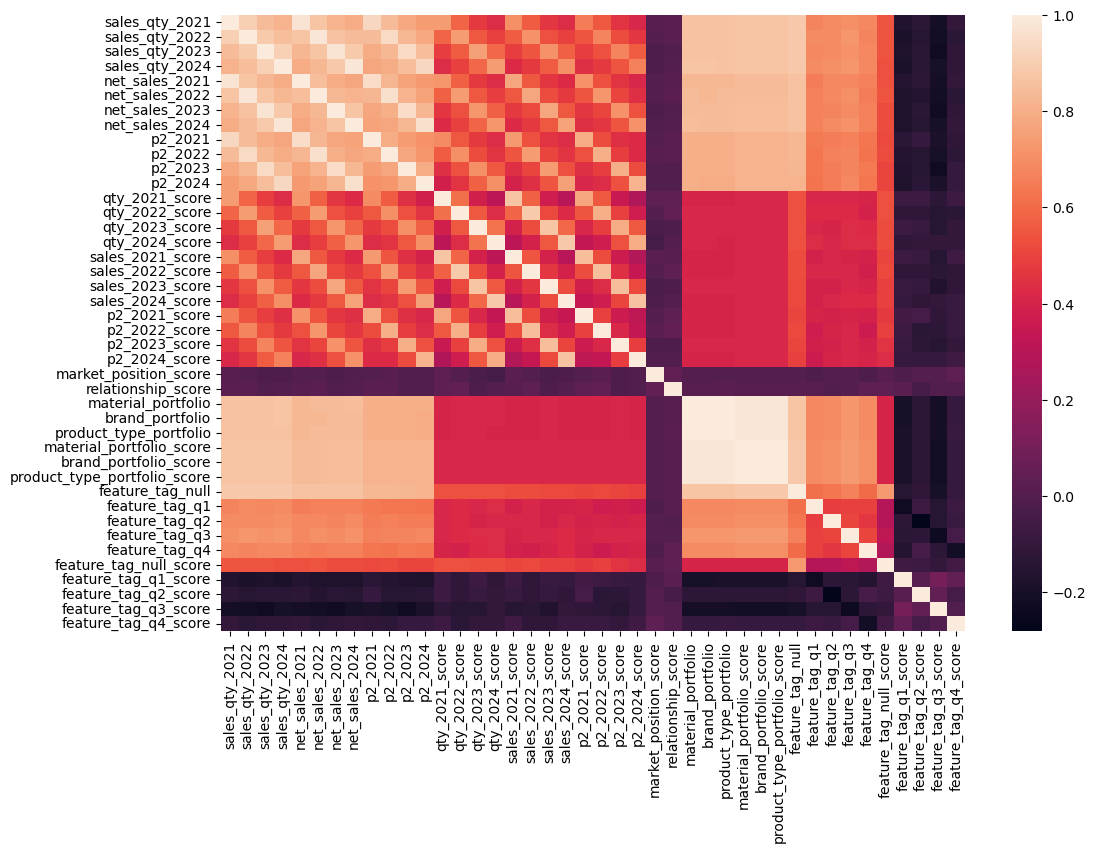

In [21]:
# mapa de correlacion

plt.subplots(figsize = (12, 8))
sns.heatmap(data = df_select_data._get_numeric_data().corr().round(2),
            #annot = True
            )
plt.show()

### Observaciones de correlacion

* Las correlaciones son fuertes con datos dentro de sus propios años cuando se trata de volumen de ventas (qty y sales)
* existe una correlacion directa entre las ventas y los material/brand/product_type/feature_tags
* hay correlacion medianamente directa entre las cantidades vendidas y material/brand/product_type/feature_tags
* no existe correlacion significativa entre relationship/market_position respecto de los demas atributos

**Hipotesis**: una etiqueta de posicion de mercado o una de relacion con la empresa, *aunque no sea correlativa a los factores anteriores, puede definirse en funcion de estos como sus atributos*, pero no dependen una de la otra

### sales/qty vs filtered by singled tagged market position and relationship, separated

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\4052790372.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been ass

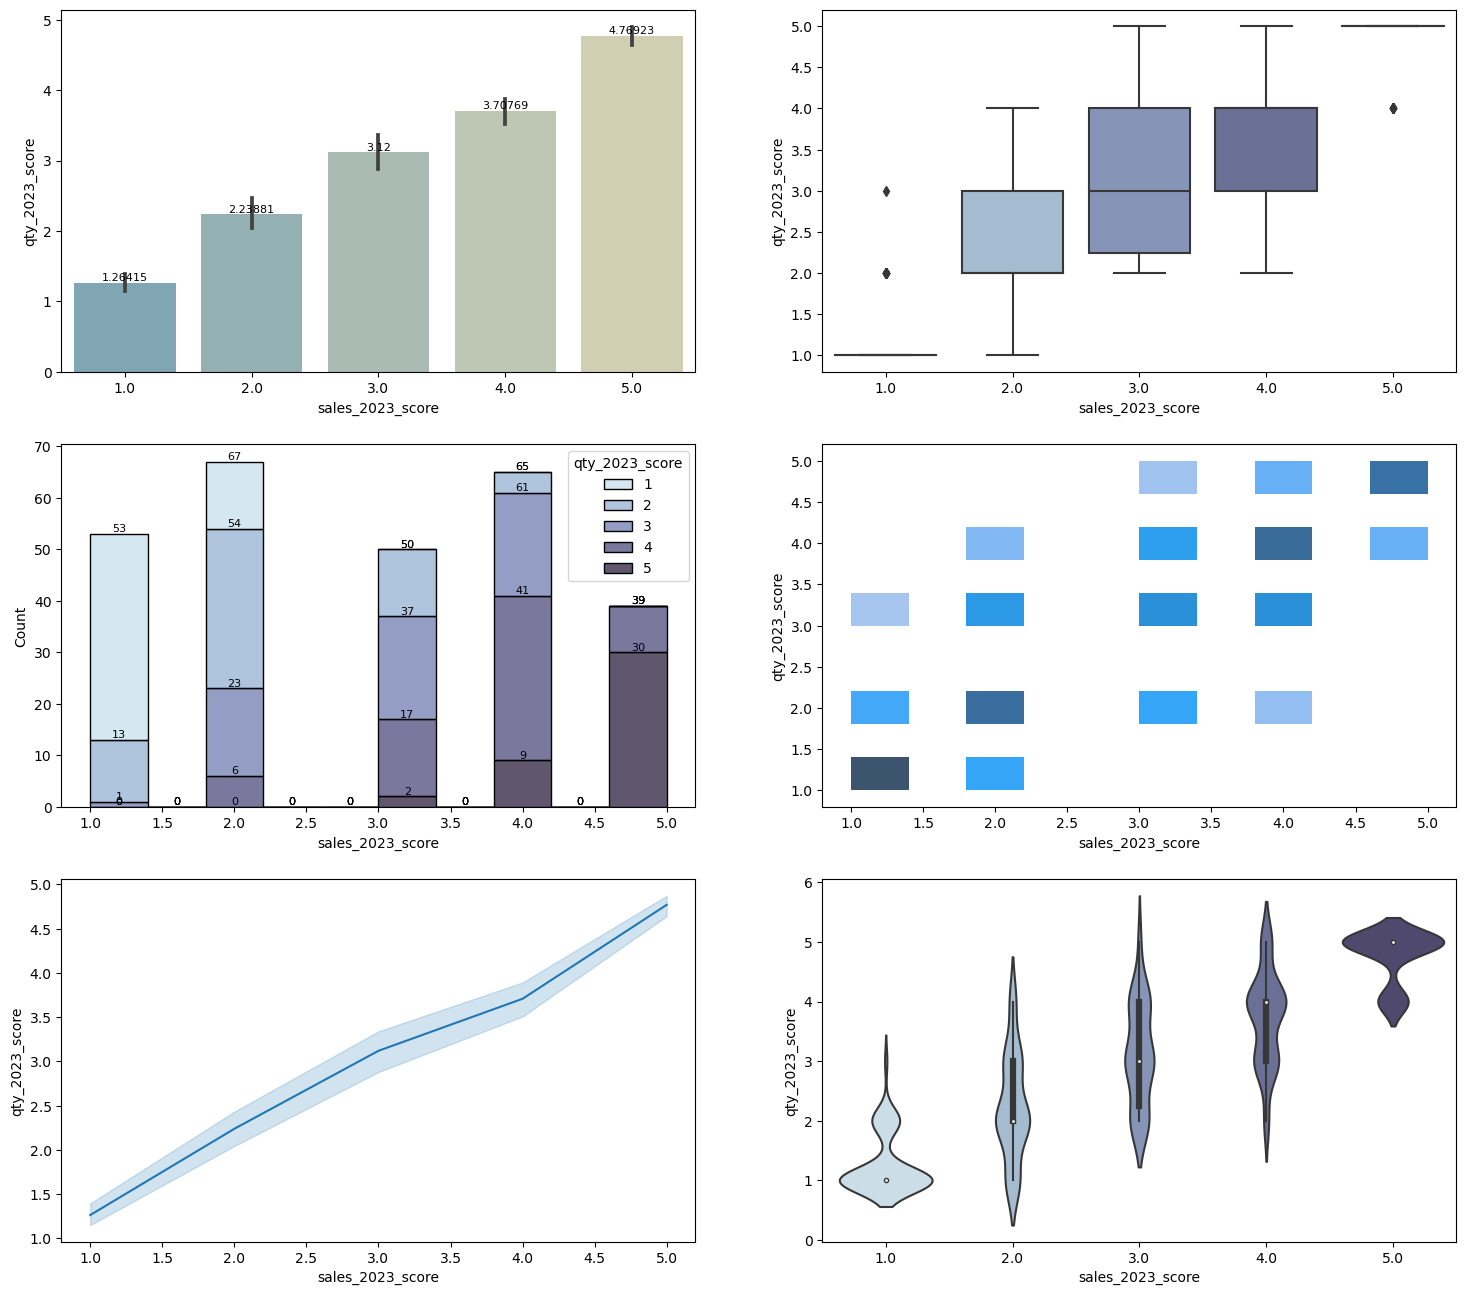

In [22]:
# comparacion entre las etiquetas de market_pos valoradas, sin considerar customers con etiquetas multiples
sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
            x_axis= 'sales_2023_score',
            y_axis= 'qty_2023_score',
            figsize= (18, 16),
            label_rotation=0)
plt.show()

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2195167747.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been ass

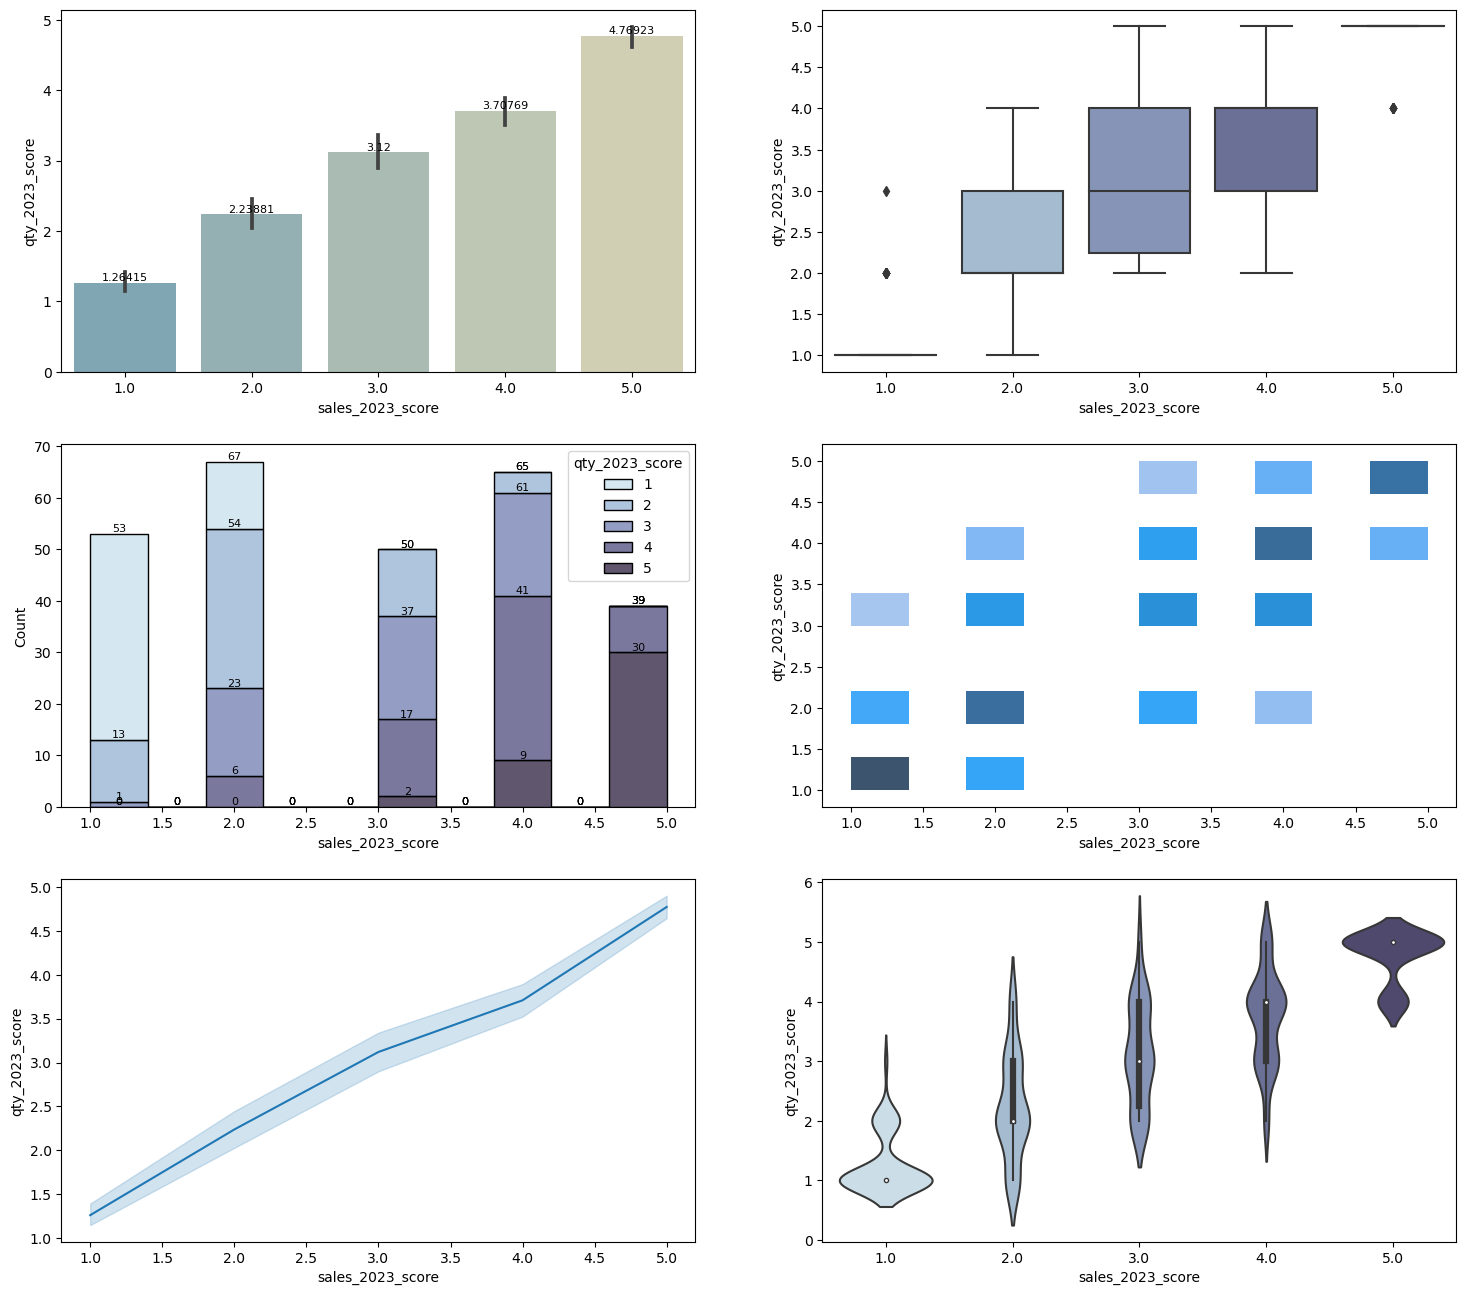

In [23]:
# comparacion entre las etiquetas de relationship valoradas, sin considerar customers con multiples etiquetas
sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
            x_axis= 'sales_2023_score',
            y_axis= 'qty_2023_score',
            figsize= (18, 16),
            label_rotation=0)
plt.show()

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\1399601344.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been ass

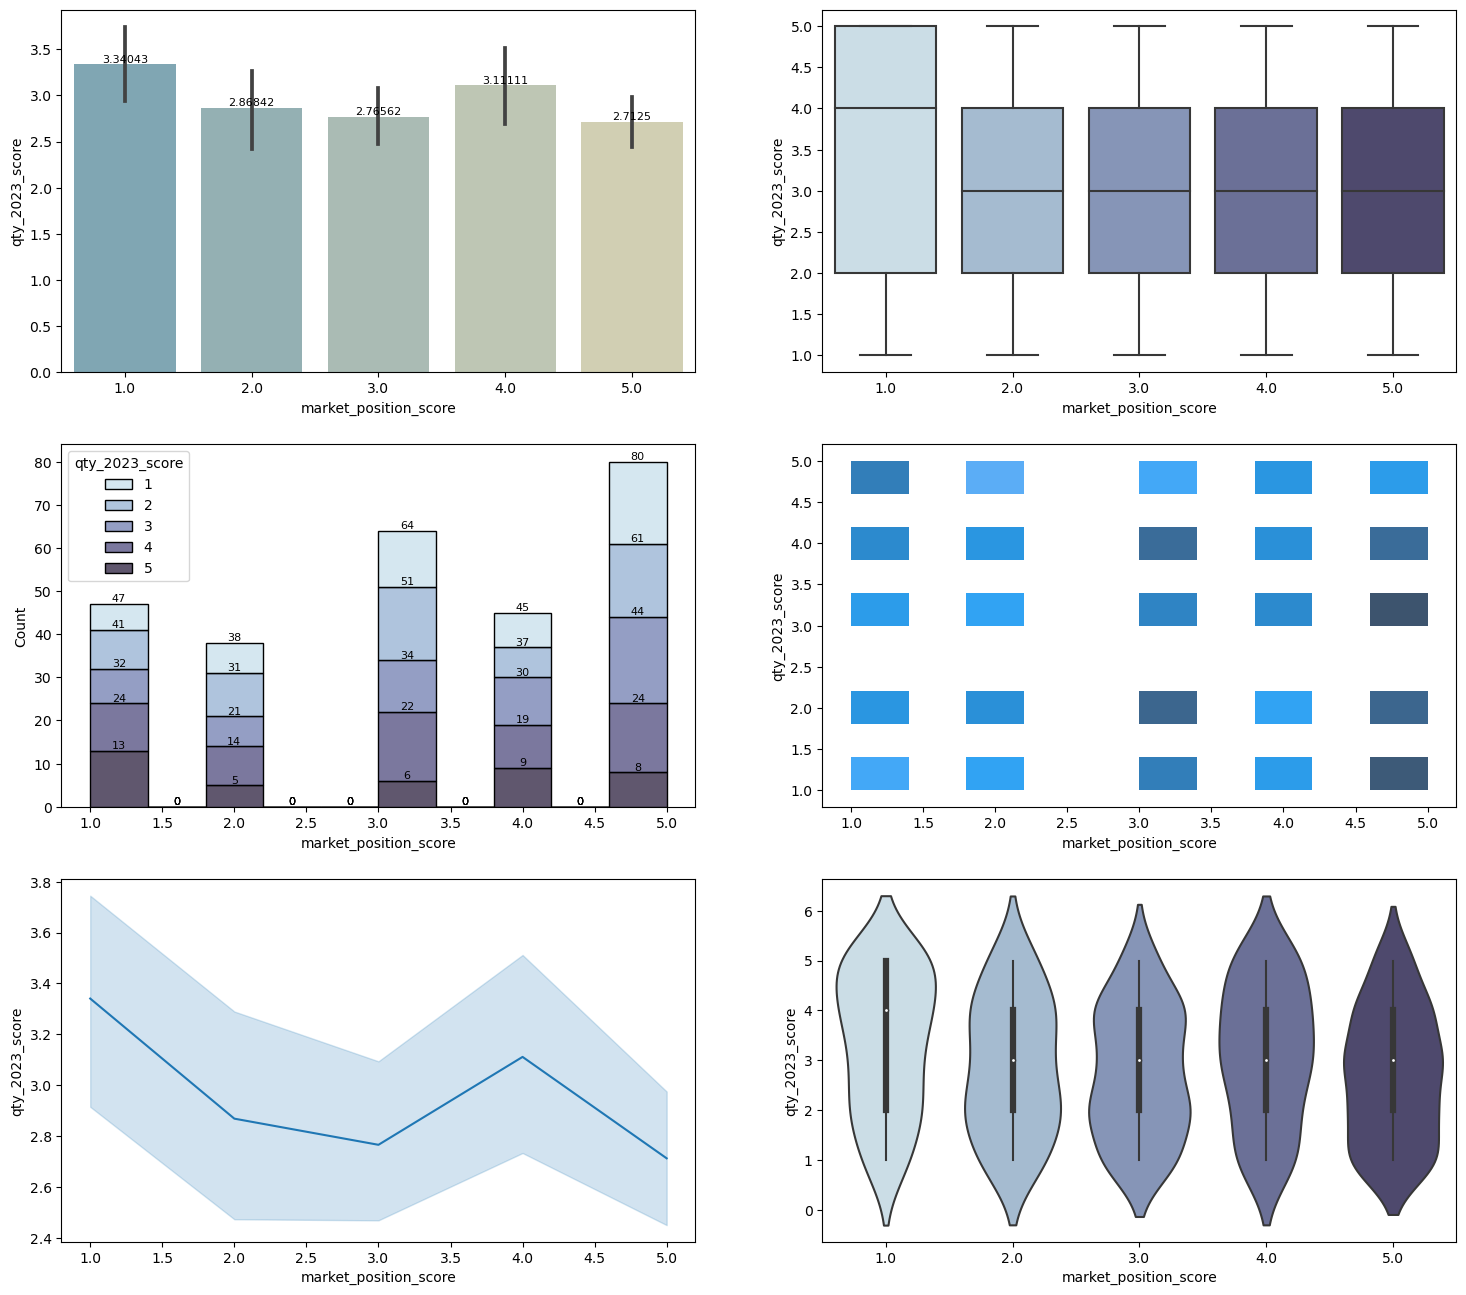

In [24]:
# market position score vs qty sold during 2023
sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
            x_axis= 'market_position_score',
            y_axis= 'qty_2023_score',
            figsize= (18, 16),
            label_rotation=0)
plt.show()

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\1363875874.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been ass

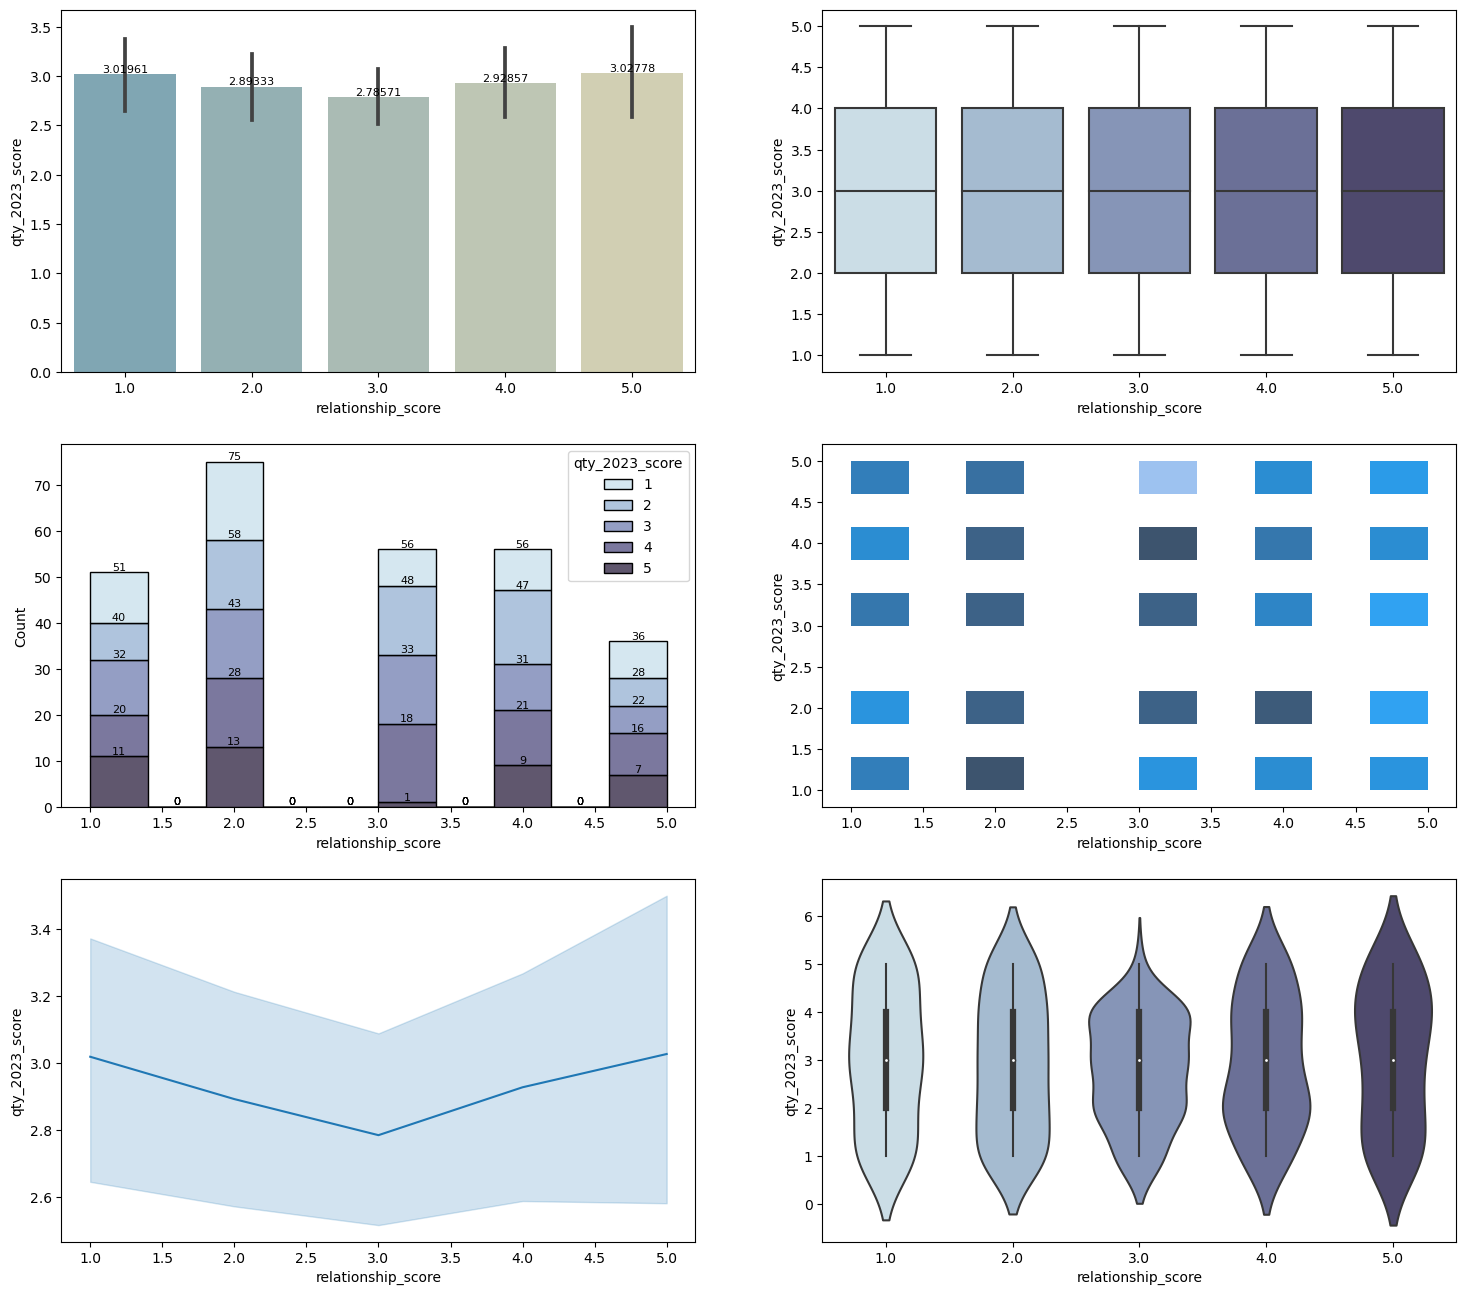

In [25]:
# relationship vs qty sold during 2023
sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
            x_axis= 'relationship_score',
            y_axis= 'qty_2023_score',
            figsize= (18, 16),
            label_rotation=0)
plt.show()

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\1740396273.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been ass

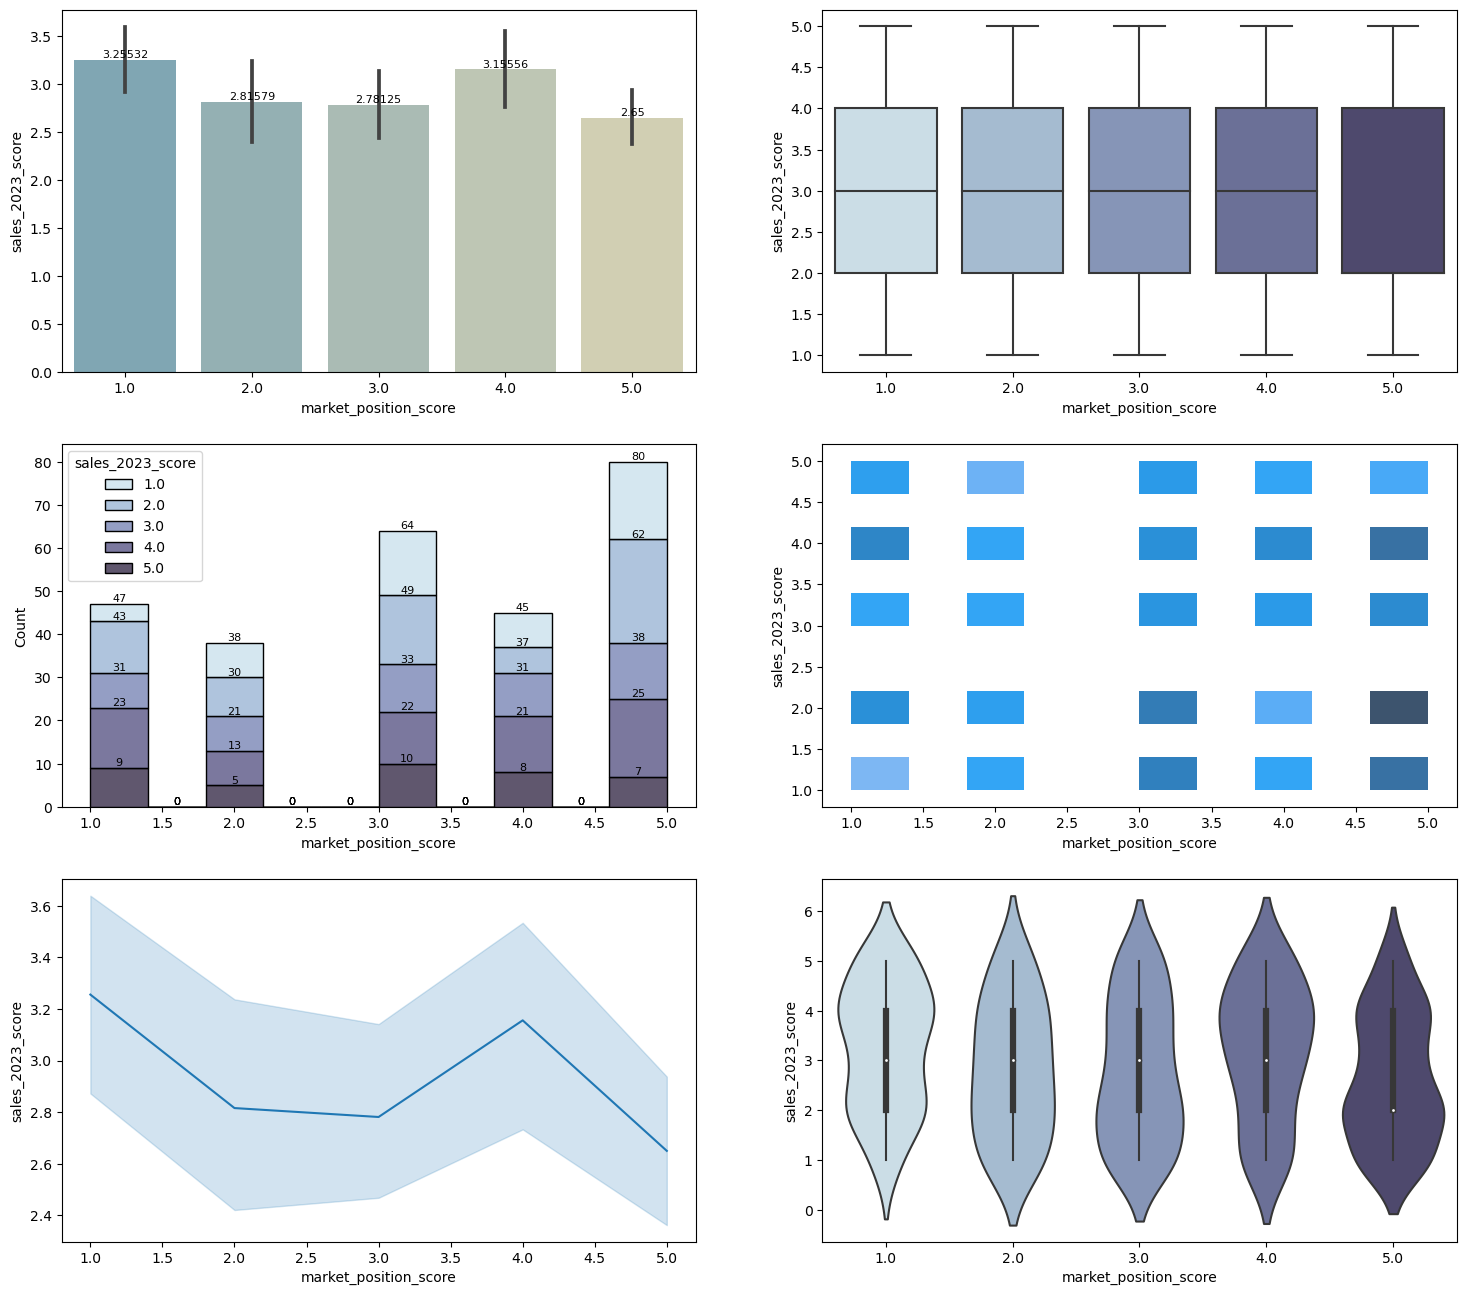

In [26]:
# market position vs sales during 2023
sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
            x_axis= 'market_position_score',
            y_axis= 'sales_2023_score',
            figsize= (18, 16),
            label_rotation=0)
plt.show()

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\3494759363.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been ass

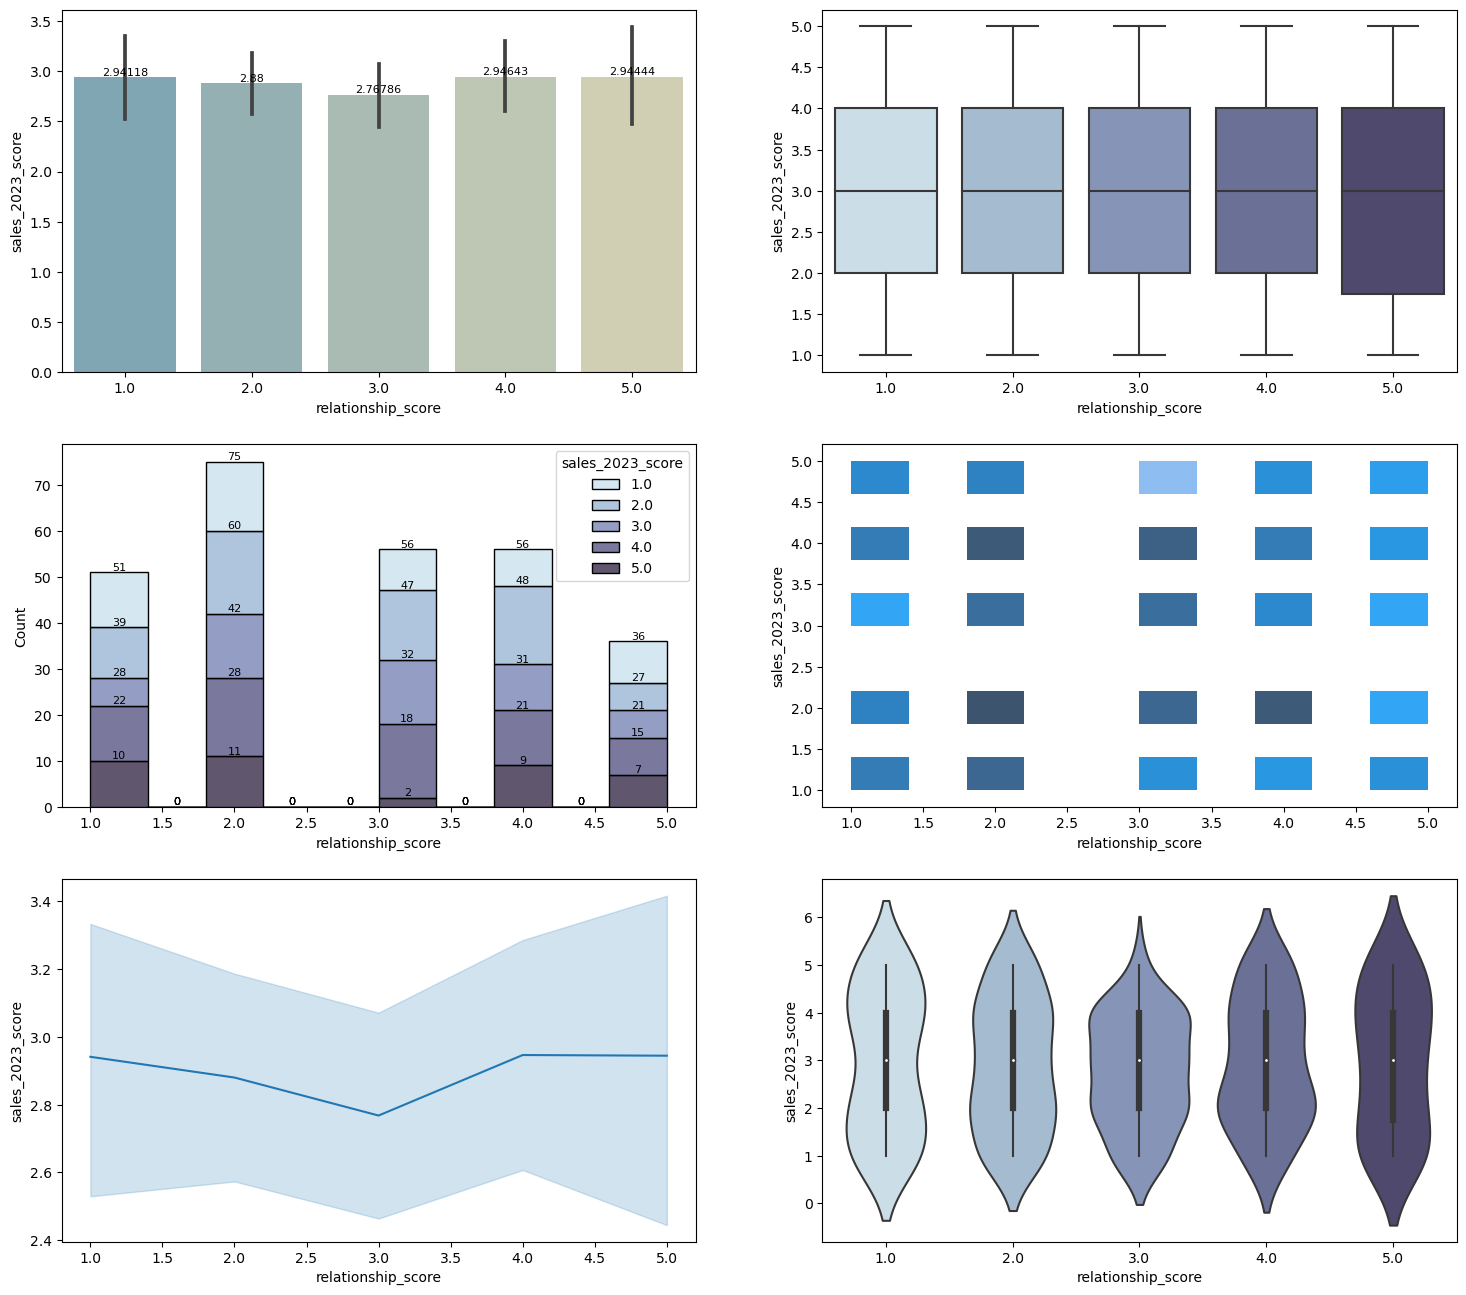

In [27]:
# relationship vs sales during 2023
sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
            x_axis= 'relationship_score',
            y_axis= 'sales_2023_score',
            figsize= (18, 16),
            label_rotation=0)
plt.show()

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\785994912.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been assi

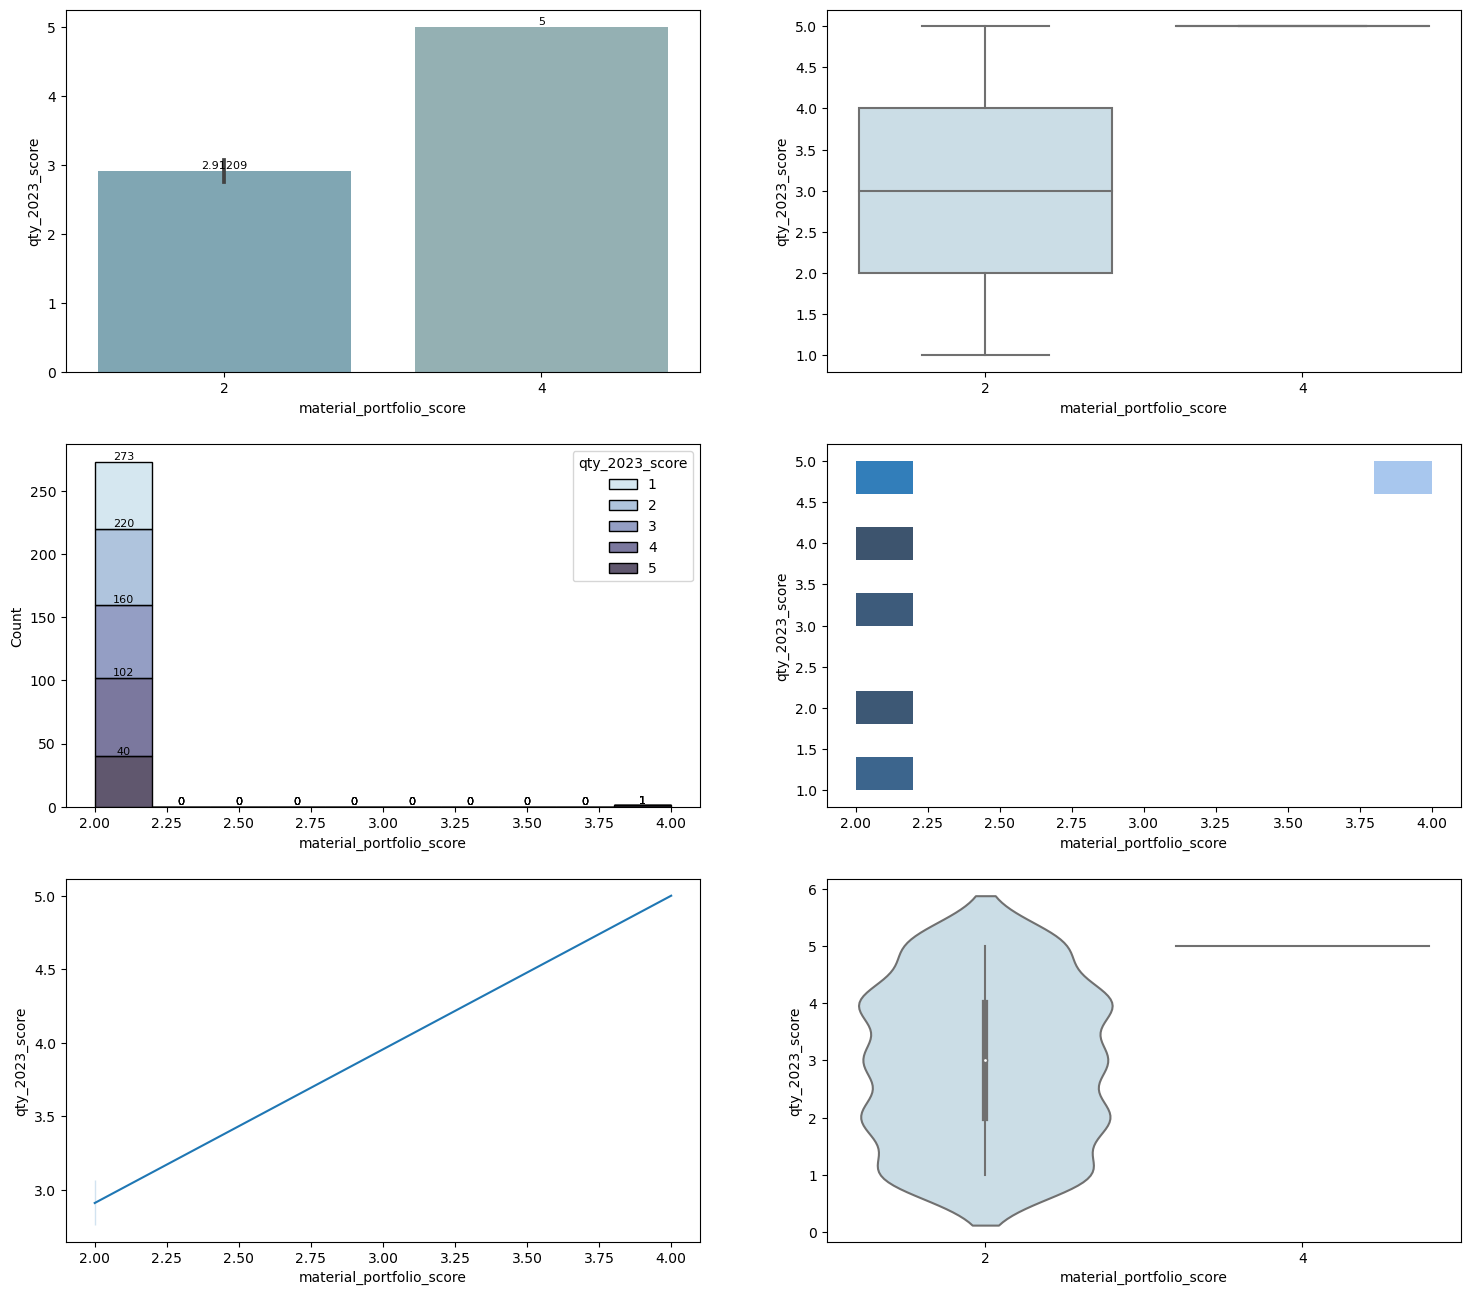

In [28]:
# material portfolio vs qty sold during 2023, related to mkt_pos
sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
            x_axis= 'material_portfolio_score',
            y_axis= 'qty_2023_score',
            figsize= (18, 16),
            label_rotation=0)
plt.show()

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\3730740423.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been ass

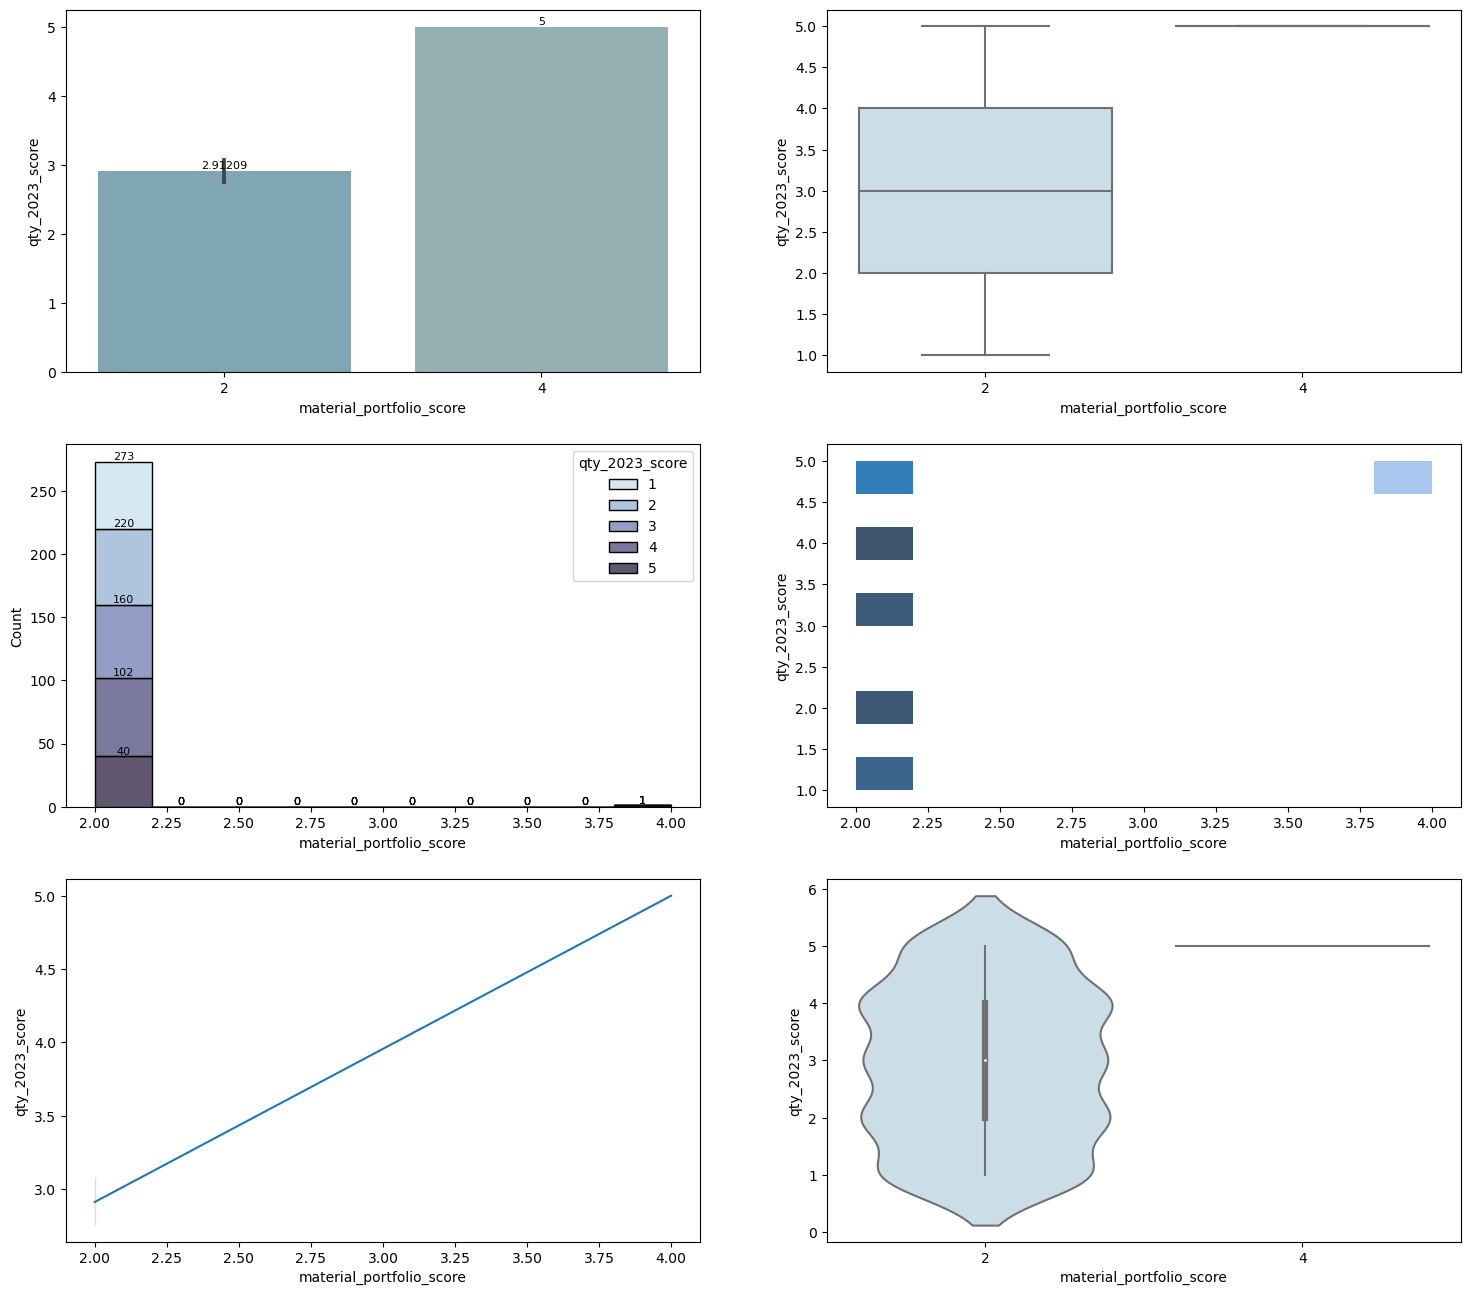

In [29]:
# material portfolio vs qty sold during 2023, related to relationship
sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
            x_axis= 'material_portfolio_score',
            y_axis= 'qty_2023_score',
            figsize= (18, 16),
            label_rotation=0)
plt.show()

### Sales/qty vs portfolio, filtered by single tagged market position and relationship

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\344617771.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been assi

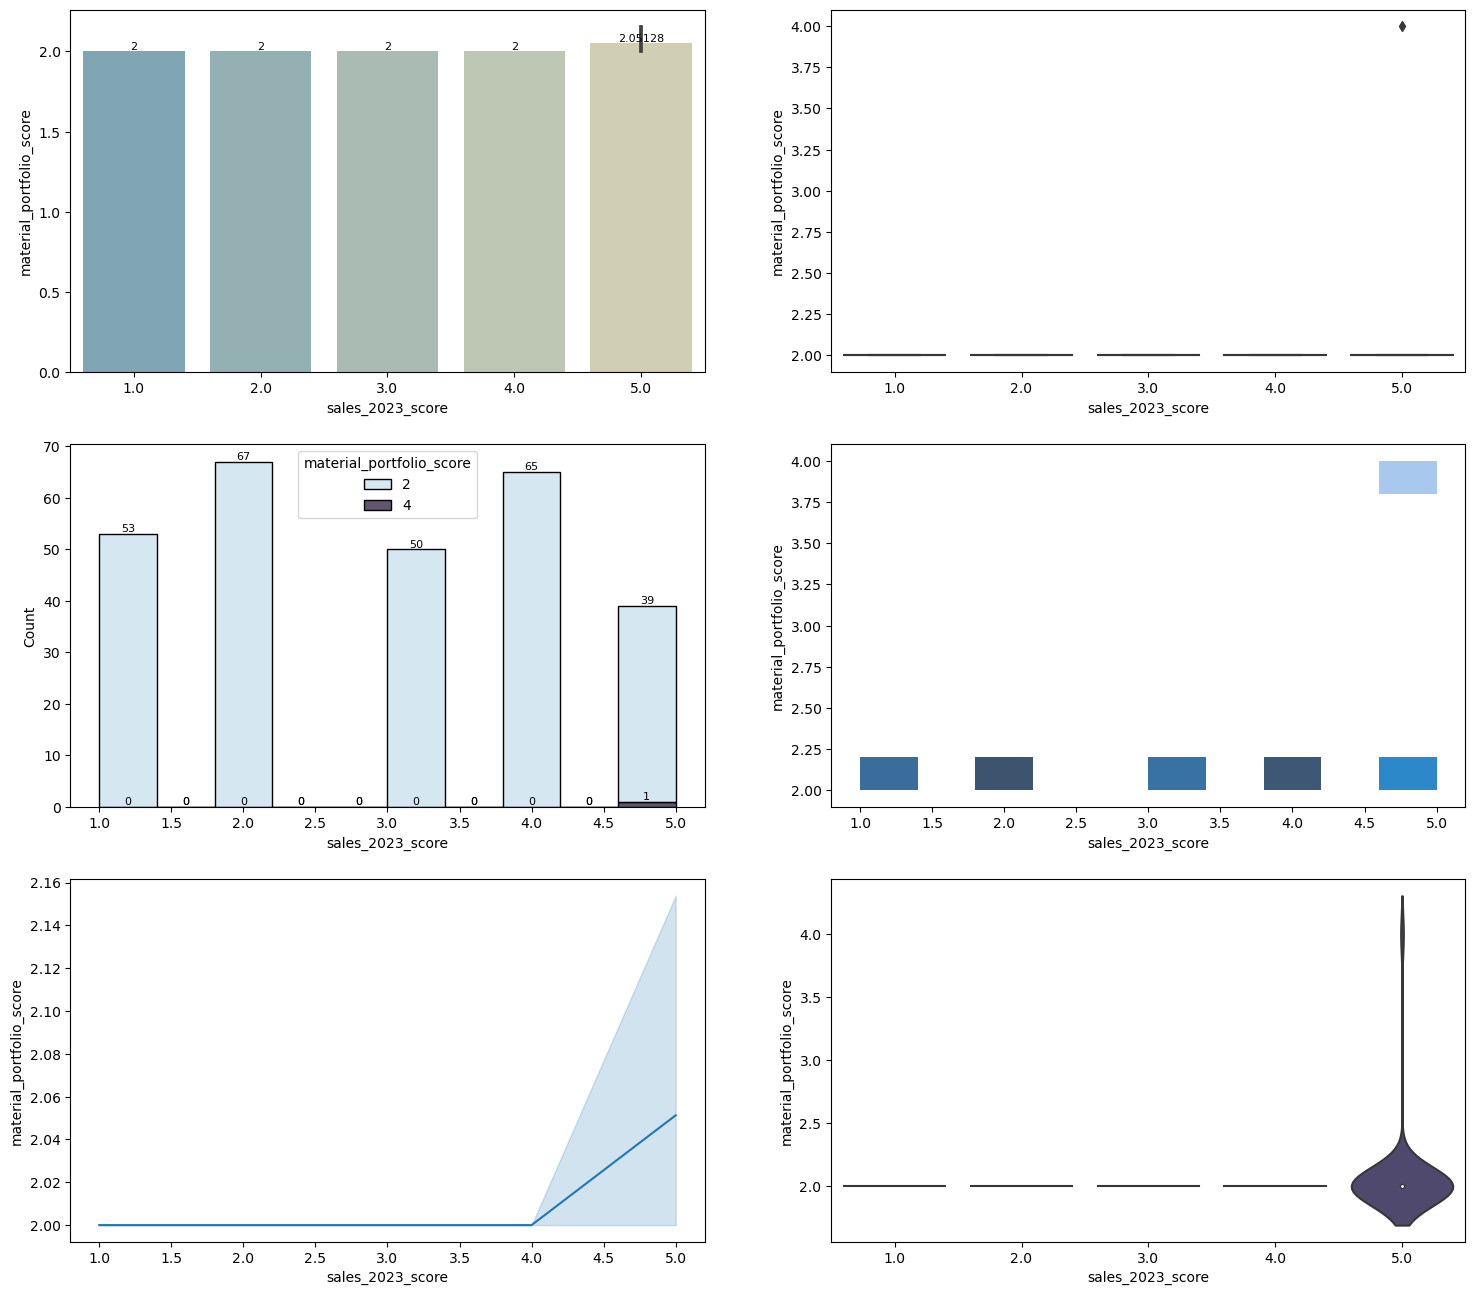

In [30]:
sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
            x_axis= 'sales_2023_score',
            y_axis= 'material_portfolio_score',
            figsize= (18, 16),
            label_rotation=0)
plt.show()

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2623504251.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been ass

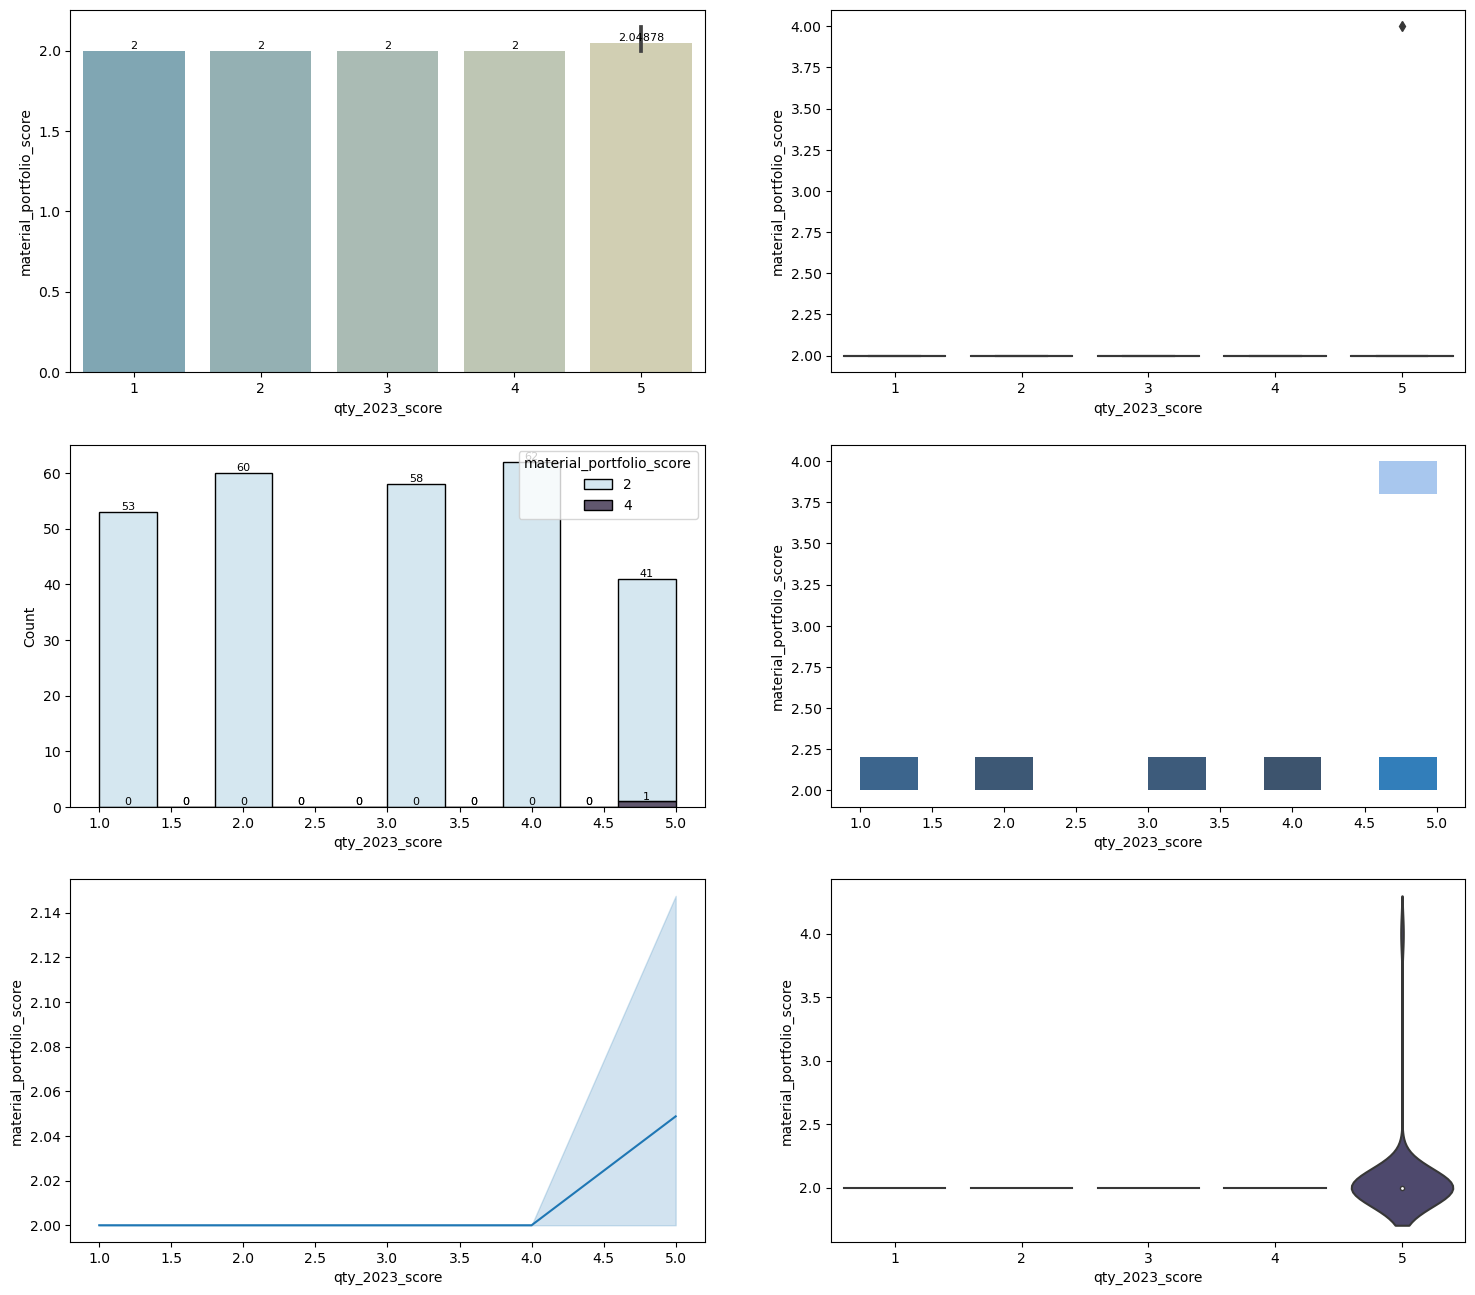

In [31]:
sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
            x_axis= 'qty_2023_score',
            y_axis= 'material_portfolio_score',
            figsize= (18, 16),
            label_rotation=0)
plt.show()

### portfolio vs customers, single tagged

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\1641876212.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)].sort_values('relationship_score',ascending=True),
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring

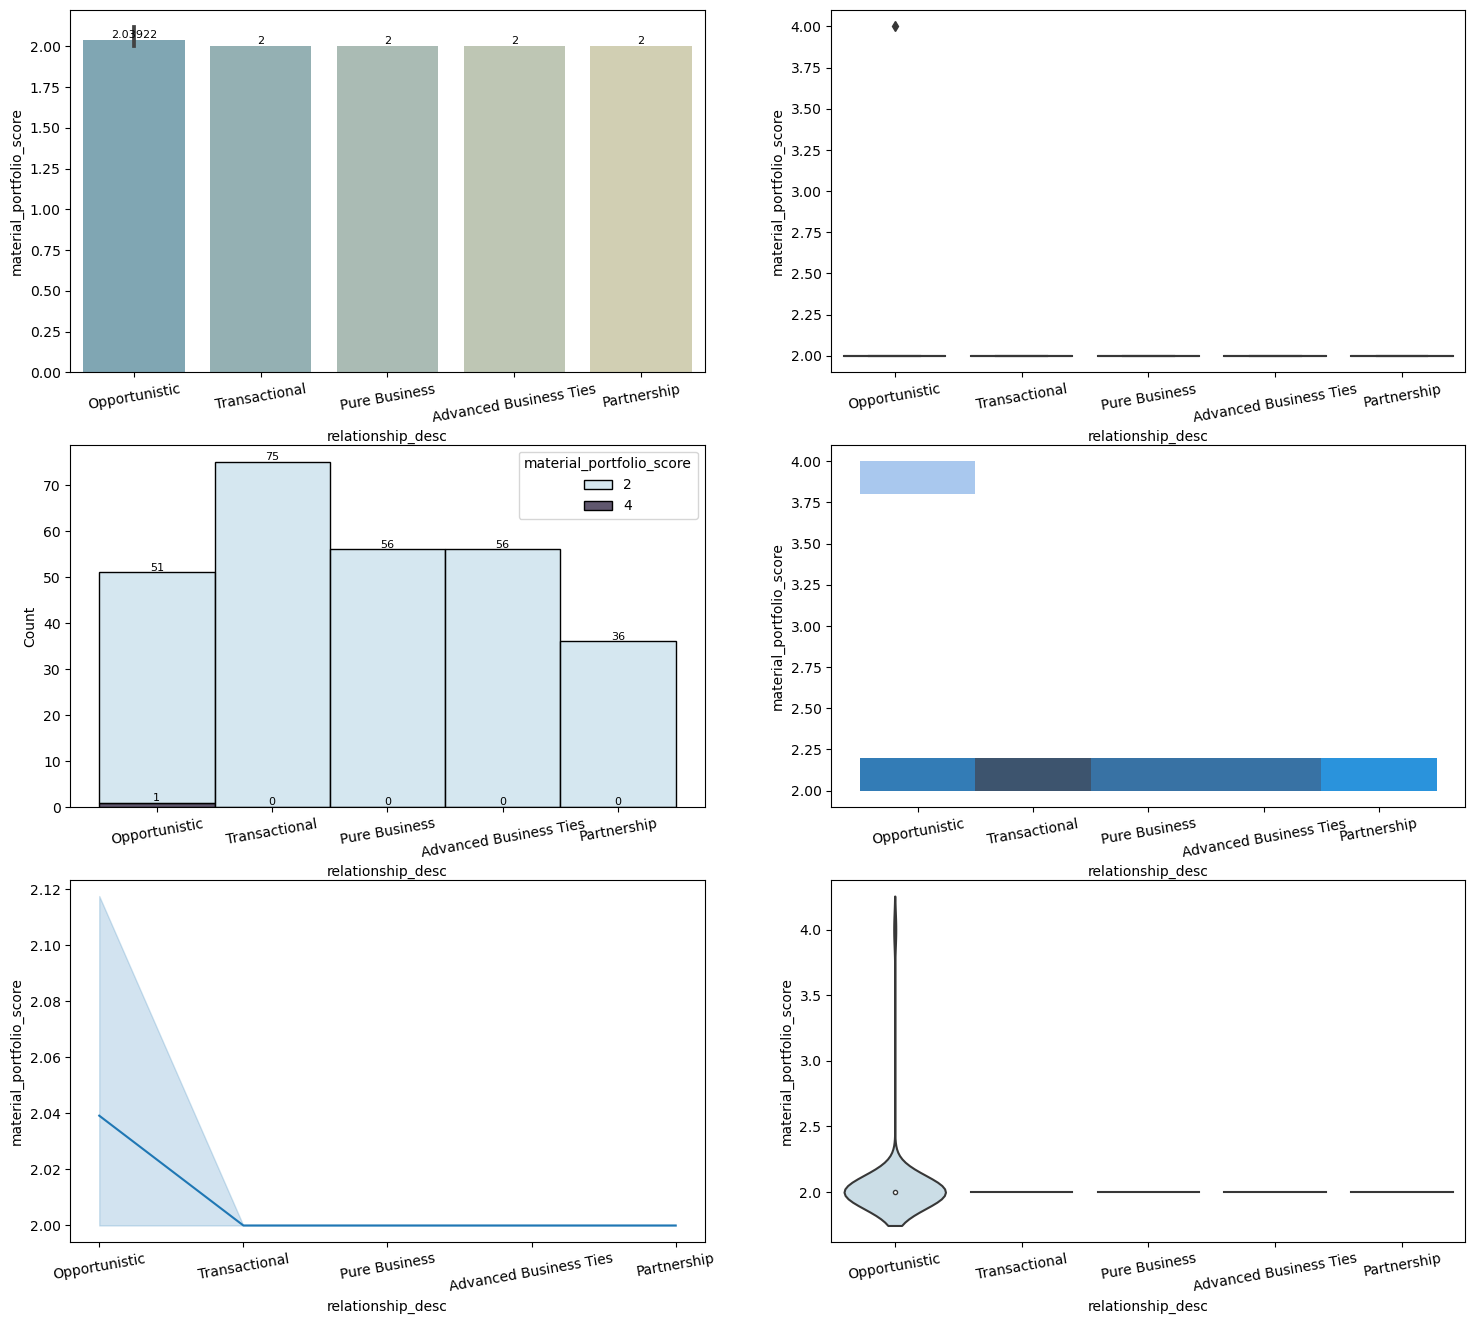

In [32]:
sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)].sort_values('relationship_score',ascending=True),
            x_axis= 'relationship_desc',
            y_axis= 'material_portfolio_score',
            figsize= (18, 16),
            label_rotation=10)
plt.show()

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\3703507712.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)].sort_values('market_position_score',ascending=True),
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignor

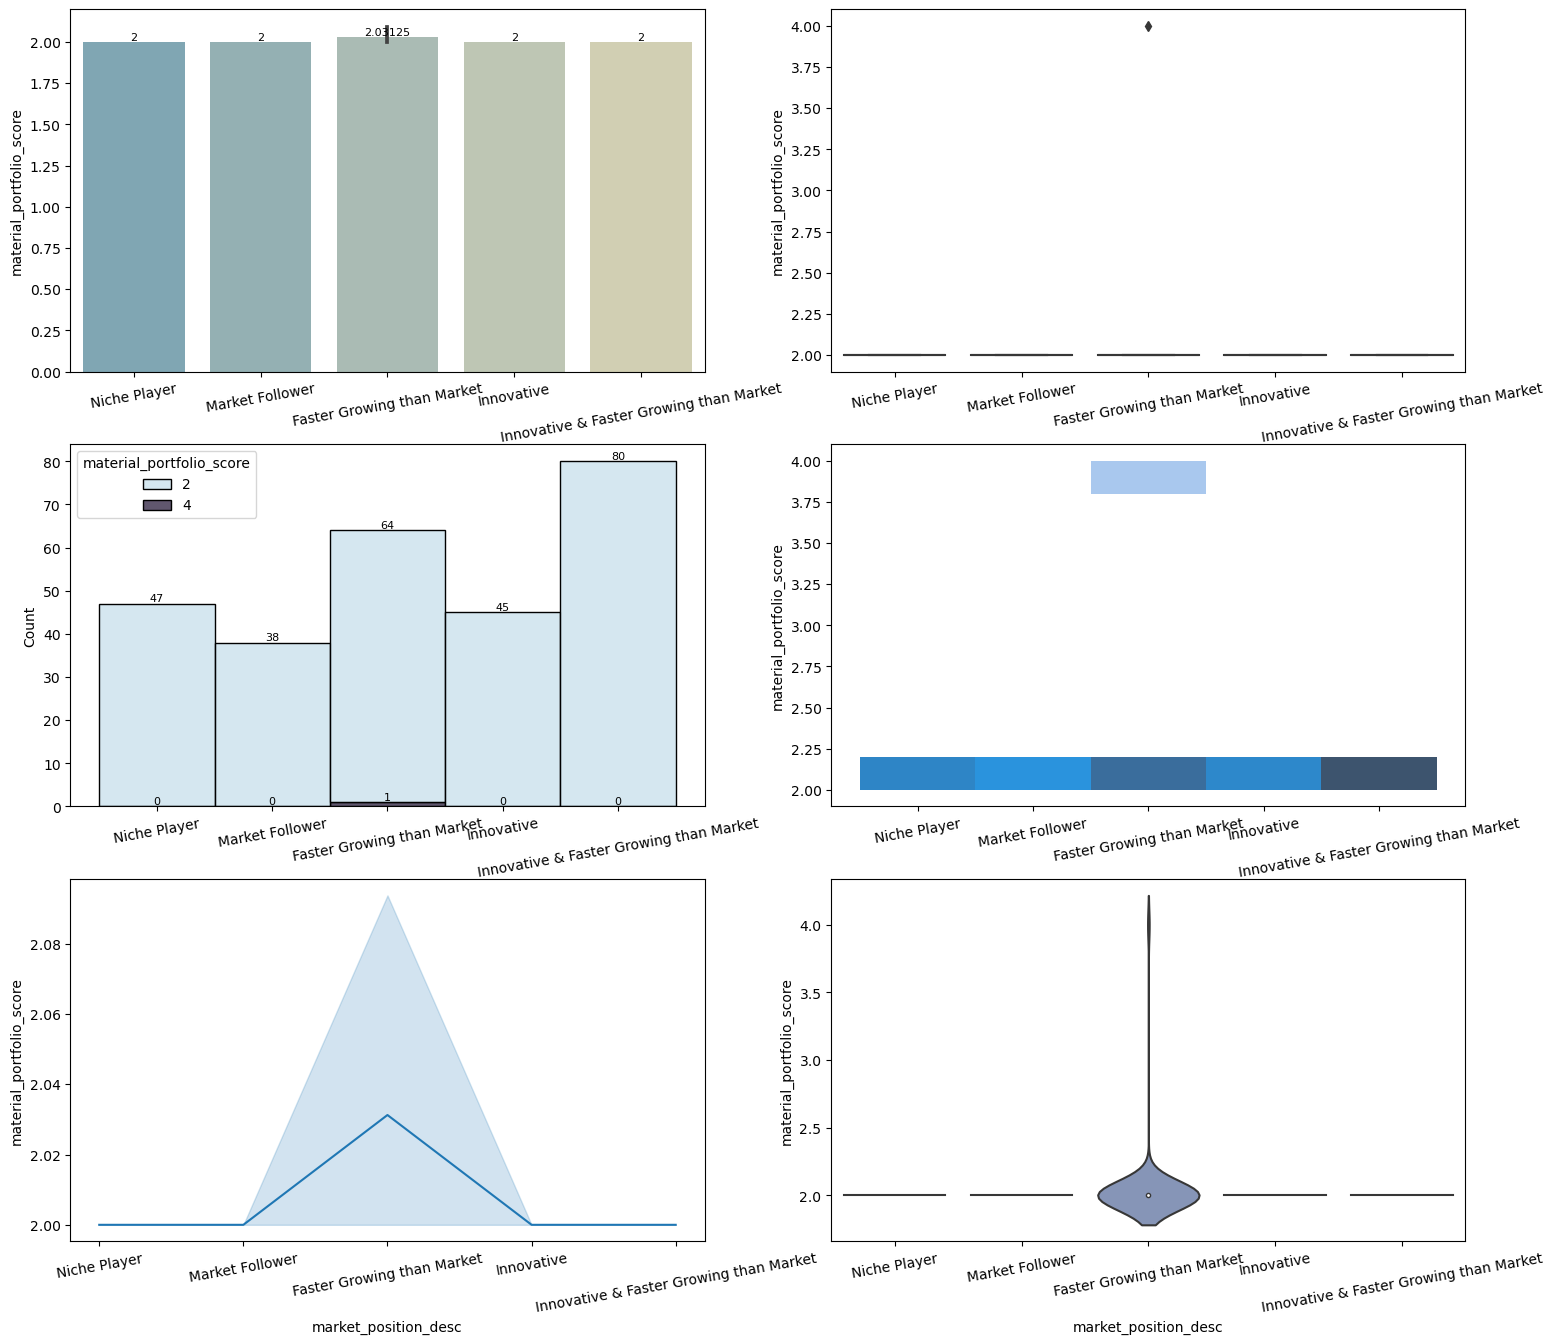

In [33]:
sea_figures(df=df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)].sort_values('market_position_score',ascending=True),
            x_axis= 'market_position_desc',
            y_axis= 'material_portfolio_score',
            figsize= (18, 16),
            label_rotation=10)
plt.show()

### ambiguous mkt tags, adyacent

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  l = sns.lineplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_xticklabels(l.get_xticklabels(),rotation=label_rotation)


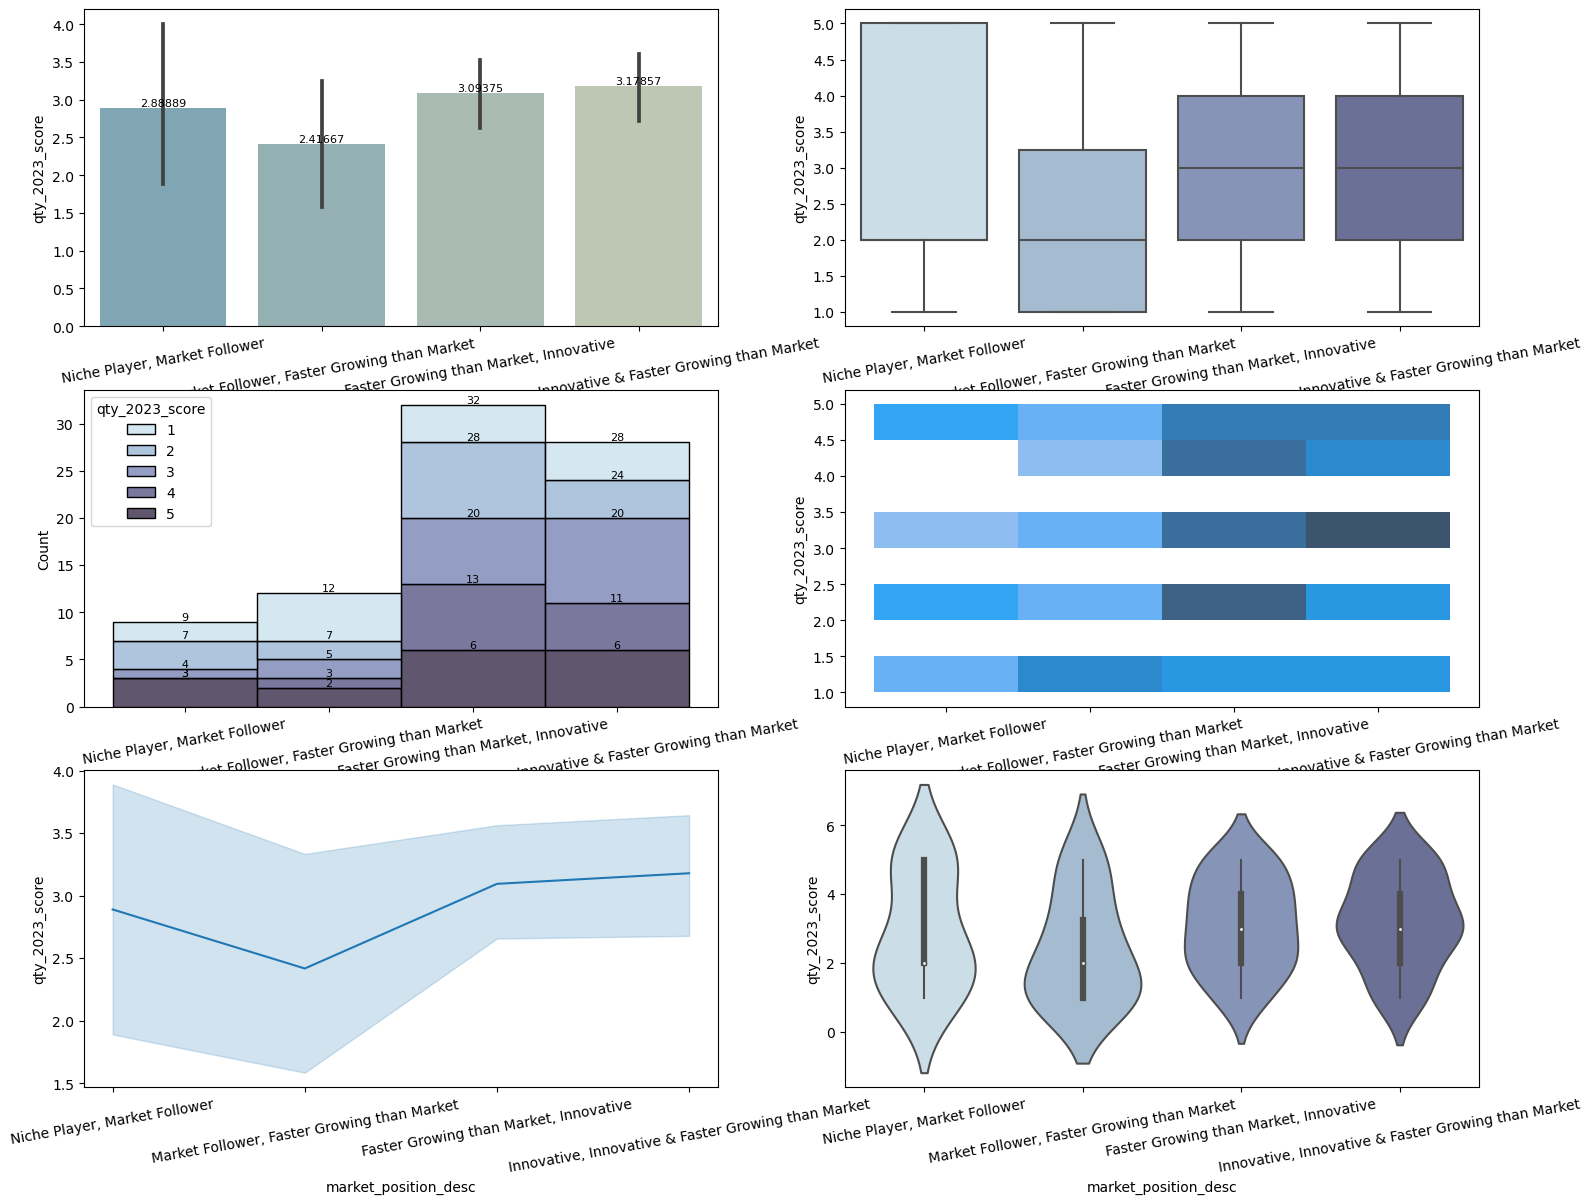

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  l = sns.lineplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_xticklabels(l.get_xticklabels(),rotation=label_rotation)


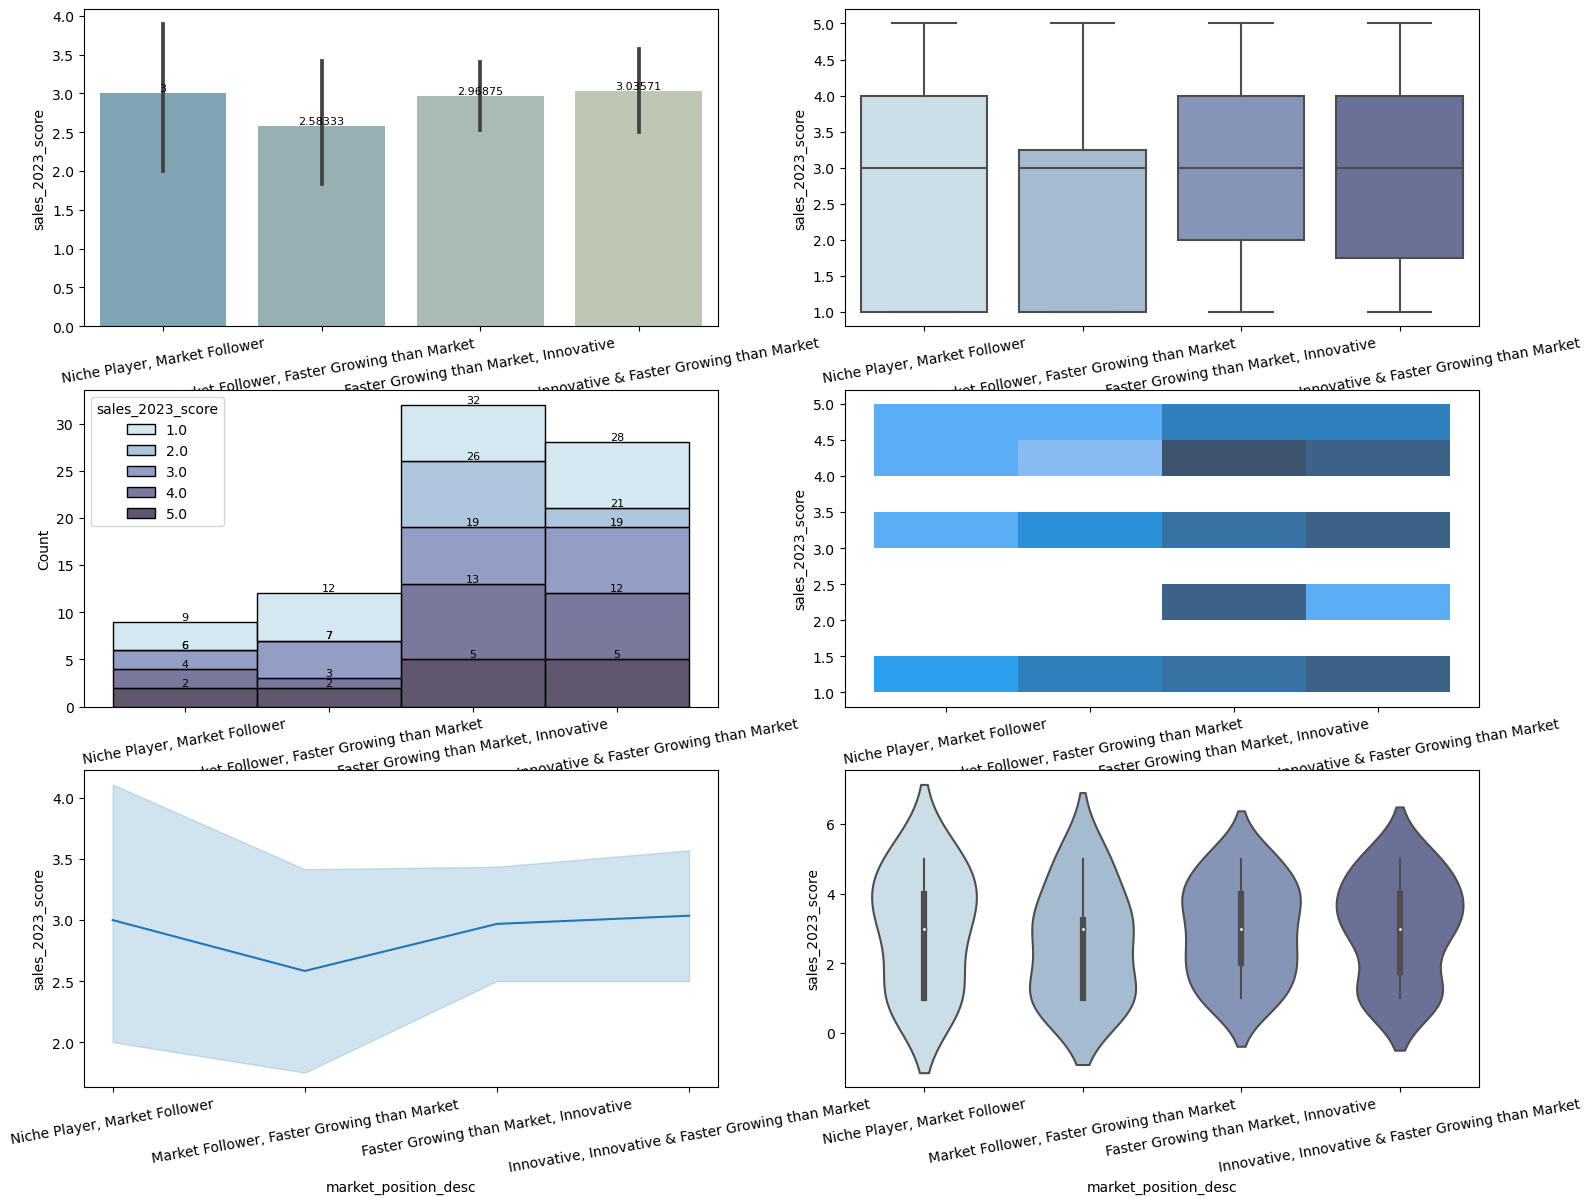

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  l = sns.lineplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_xticklabels(l.get_xticklabels(),rotation=label_rotation)


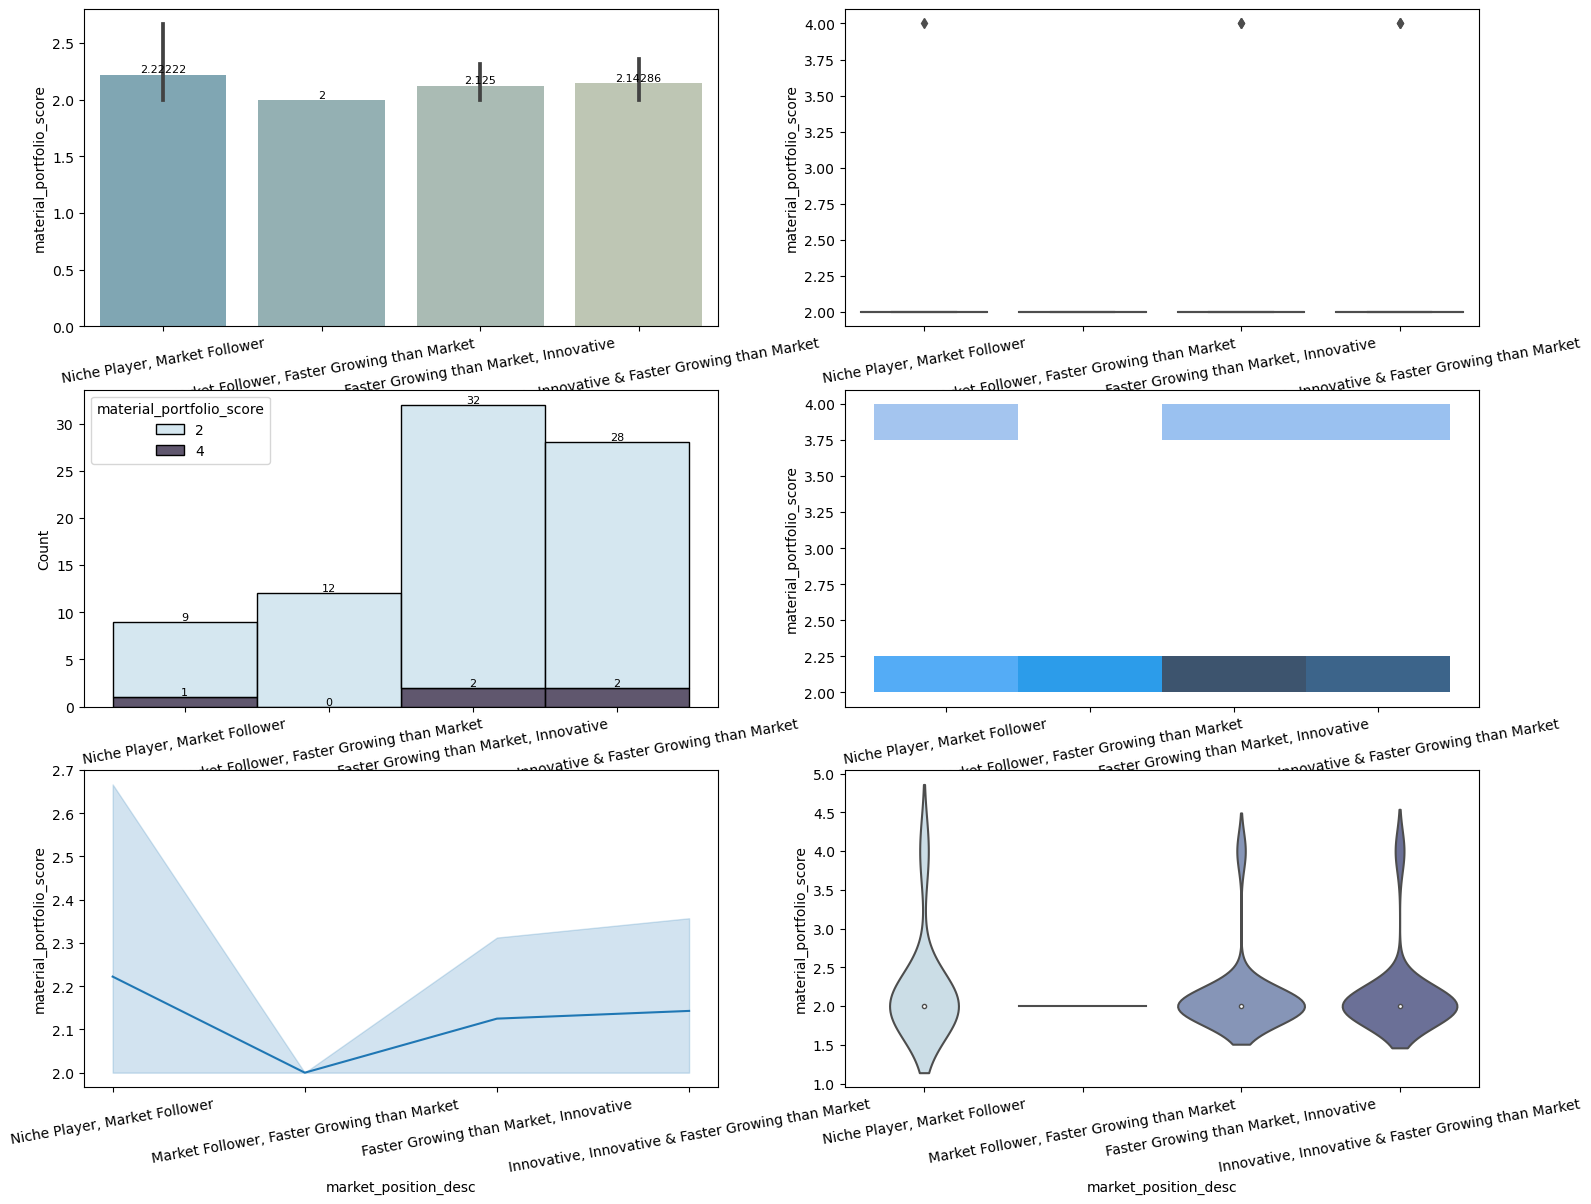

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  l = sns.lineplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_xticklabels(l.get_xticklabels(),rotation=label_rotation)


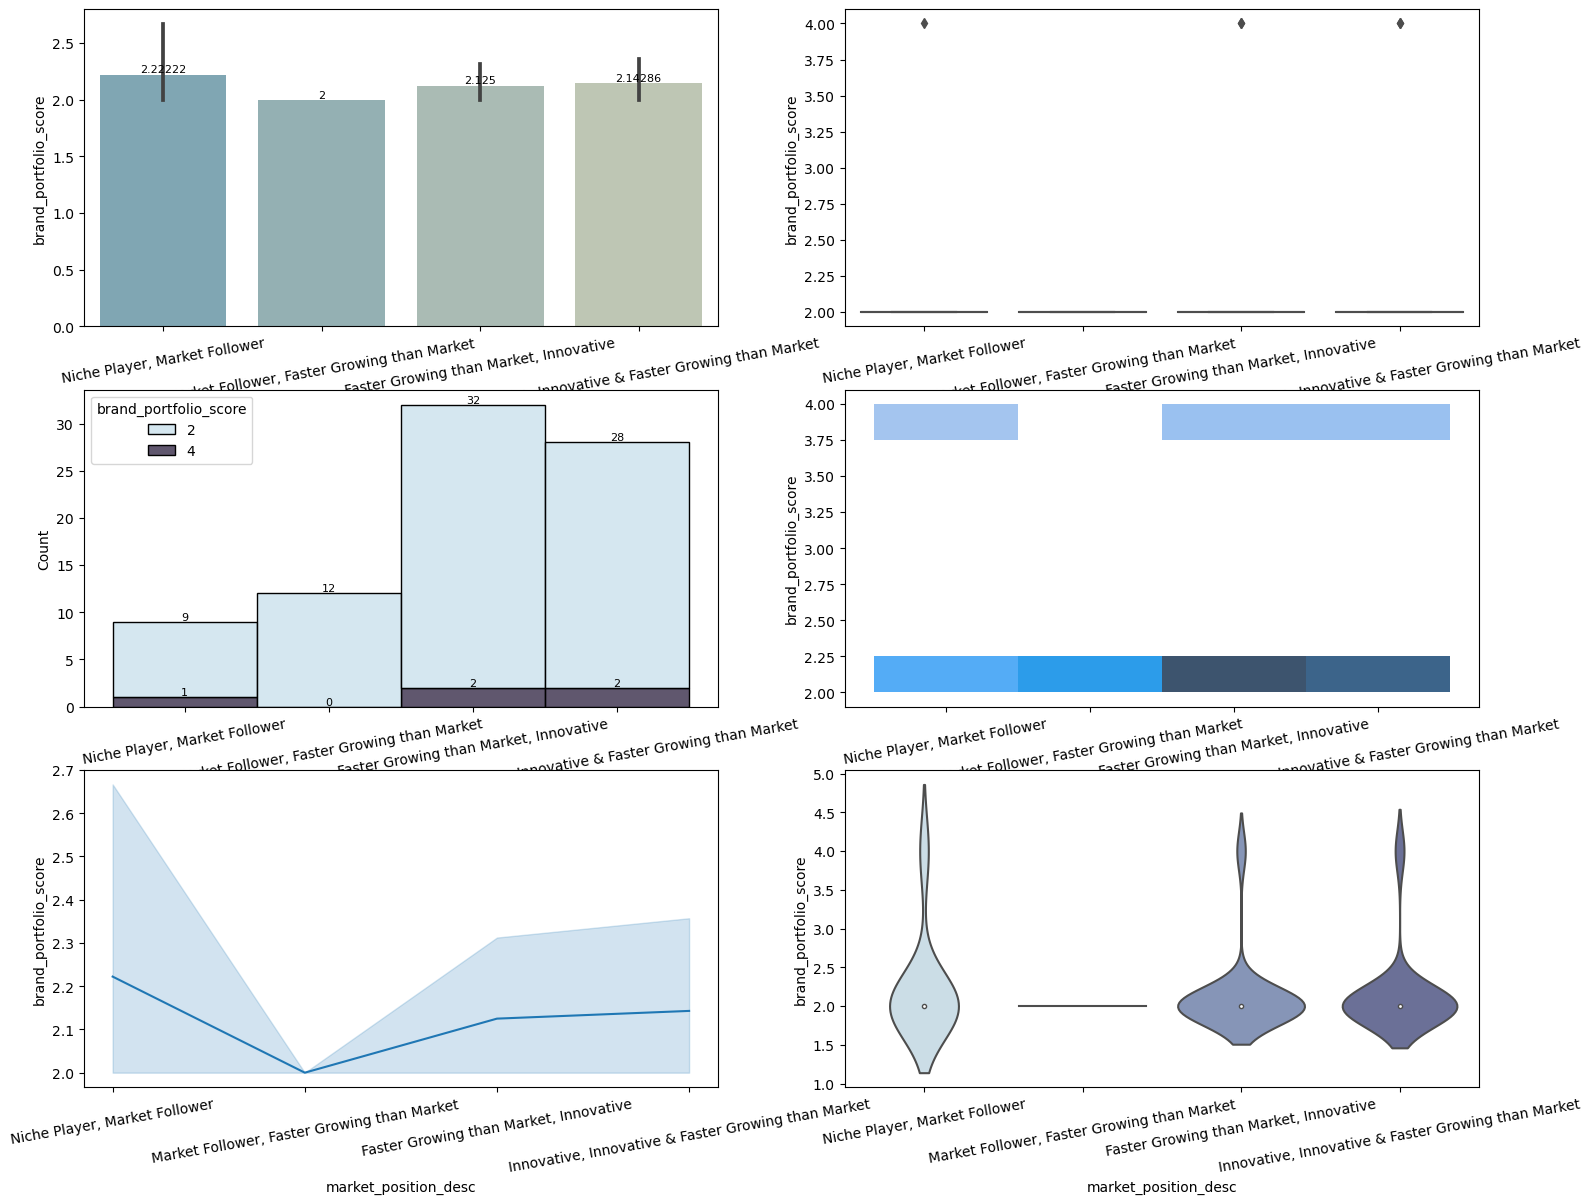

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  l = sns.lineplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_xticklabels(l.get_xticklabels(),rotation=label_rotation)


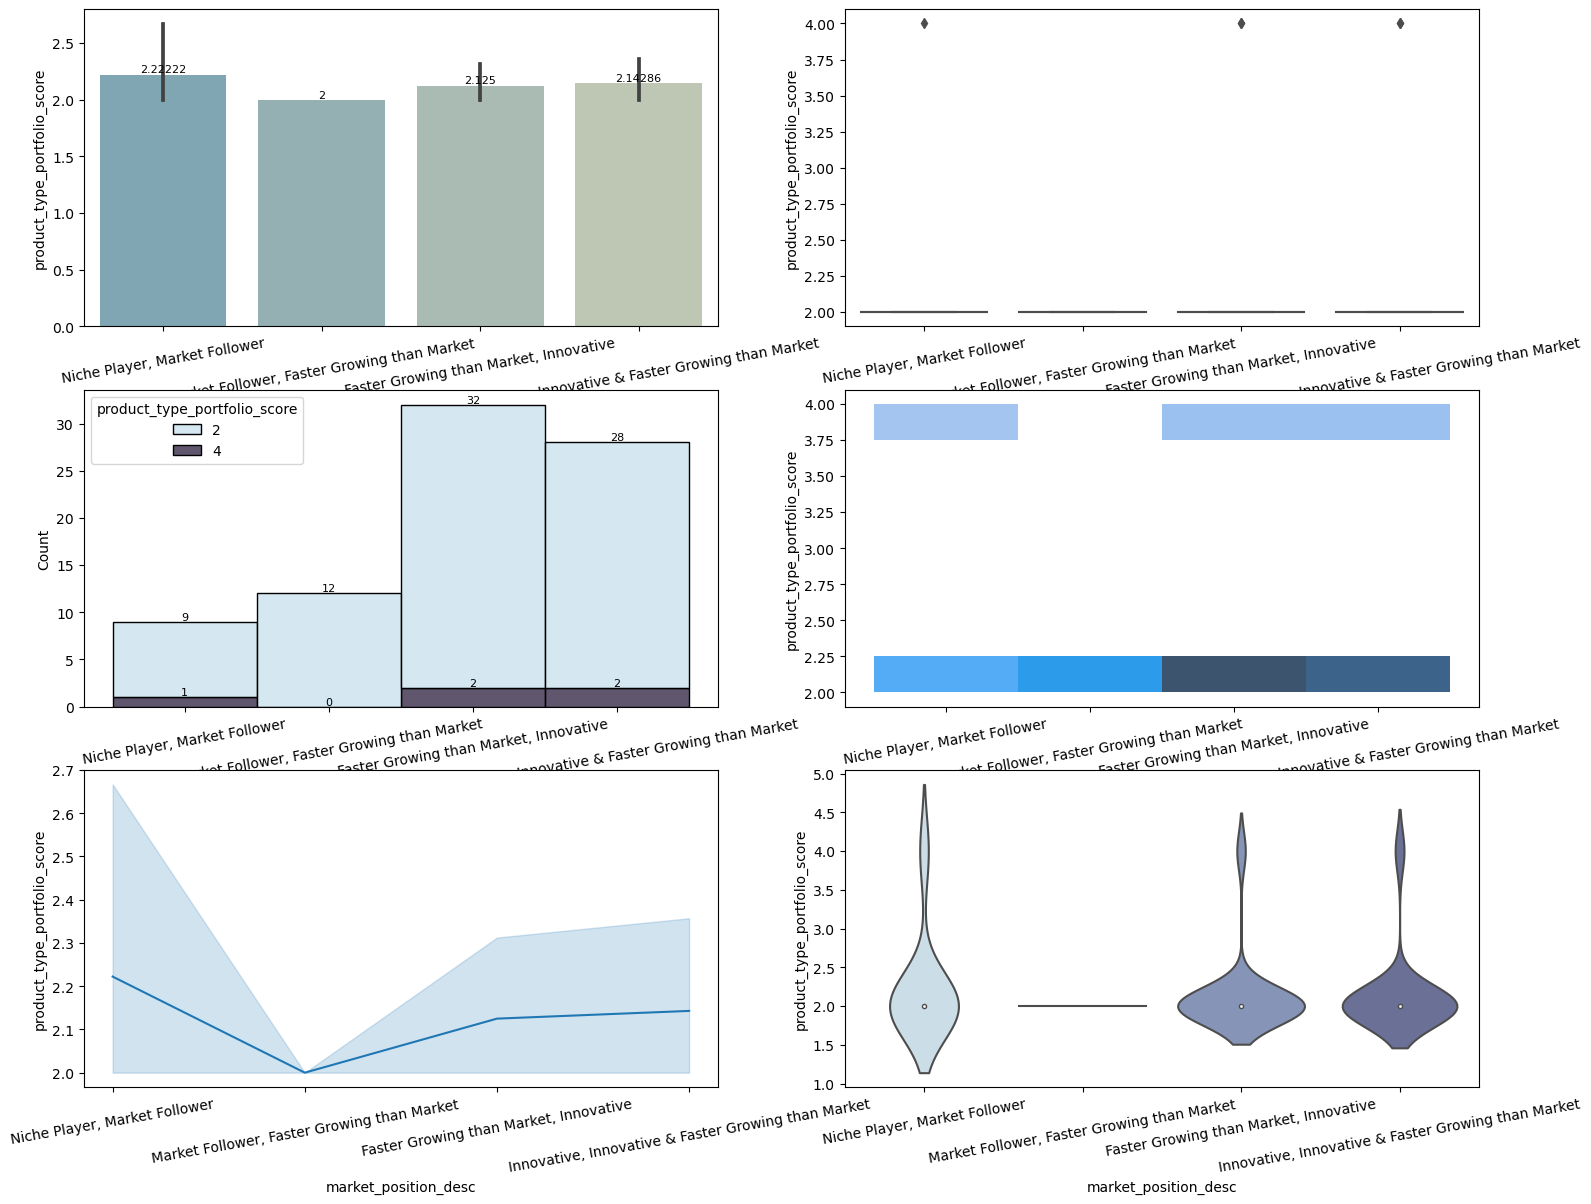

In [34]:
numcol_l = ['qty_2023_score', 'sales_2023_score', 'material_portfolio_score', 'brand_portfolio_score', 'product_type_portfolio_score']
mkt_tag_amb = ['Niche Player, Market Follower',
               'Market Follower, Faster Growing than Market',
               'Faster Growing than Market, Innovative',
               'Innovative, Innovative & Faster Growing than Market']
for c in numcol_l:
    sea_figures(df      = df_select_data[df_select_data['market_position_desc'].isin(mkt_tag_amb)].sort_values('market_position_score'),
                x_axis  = 'market_position_desc',
                y_axis  = c,
                figsize = (18,14))
    plt.show()

In [35]:
numcol_l = ['qty_2023_score', 'sales_2023_score', 'material_portfolio_score', 'brand_portfolio_score', 'product_type_portfolio_score']

### ambiguous relationship tags, adyacent

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  l = sns.lineplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_xticklabels(l.get_xticklabels(),rotation=label_rotation)


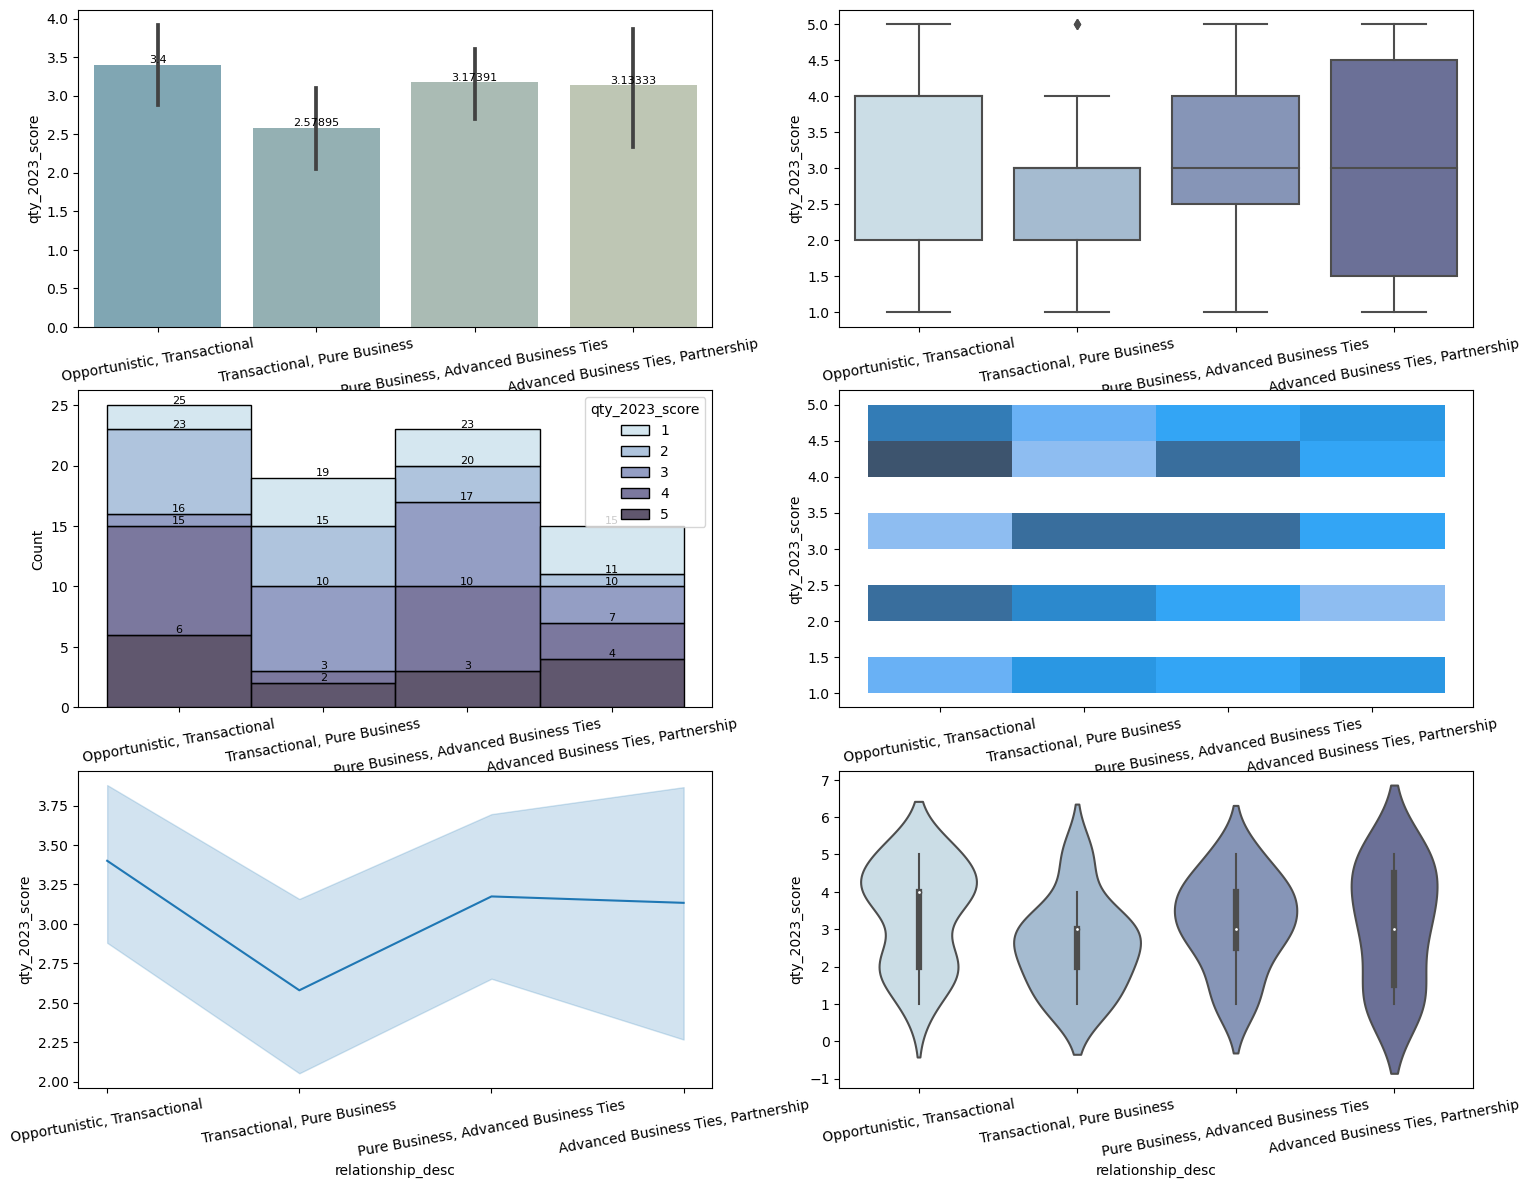

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  l = sns.lineplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_xticklabels(l.get_xticklabels(),rotation=label_rotation)


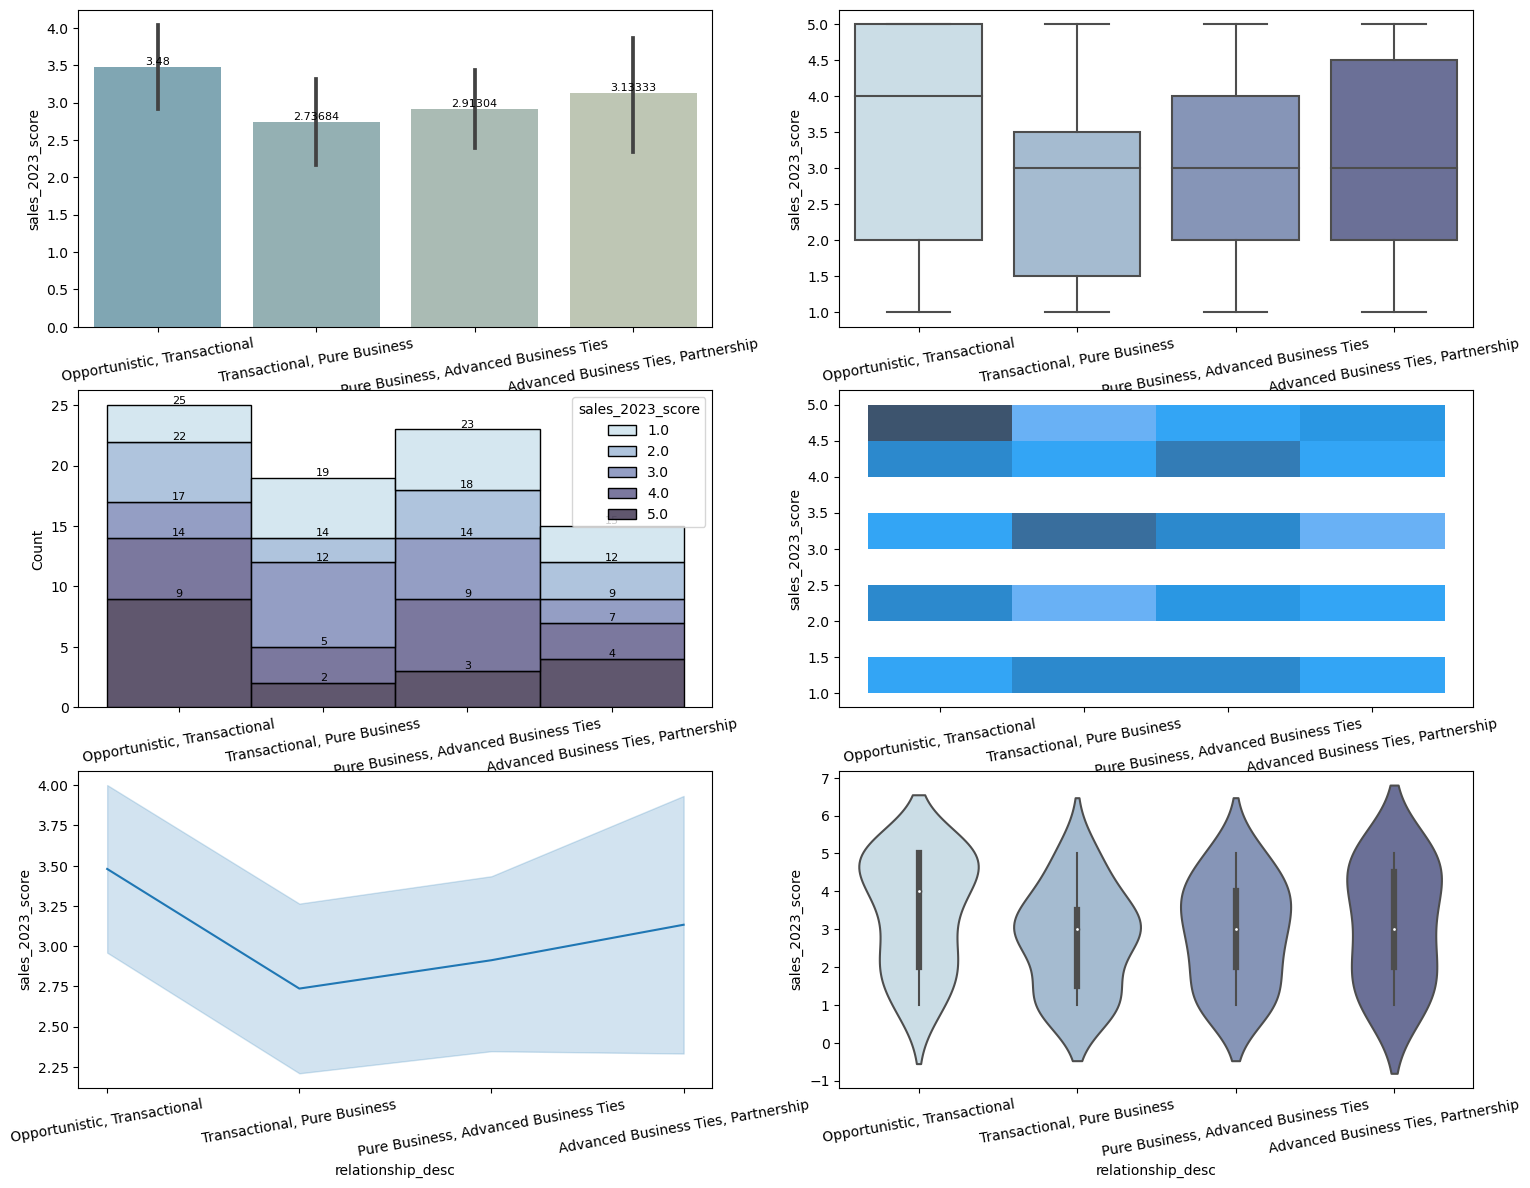

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  l = sns.lineplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_xticklabels(l.get_xticklabels(),rotation=label_rotation)


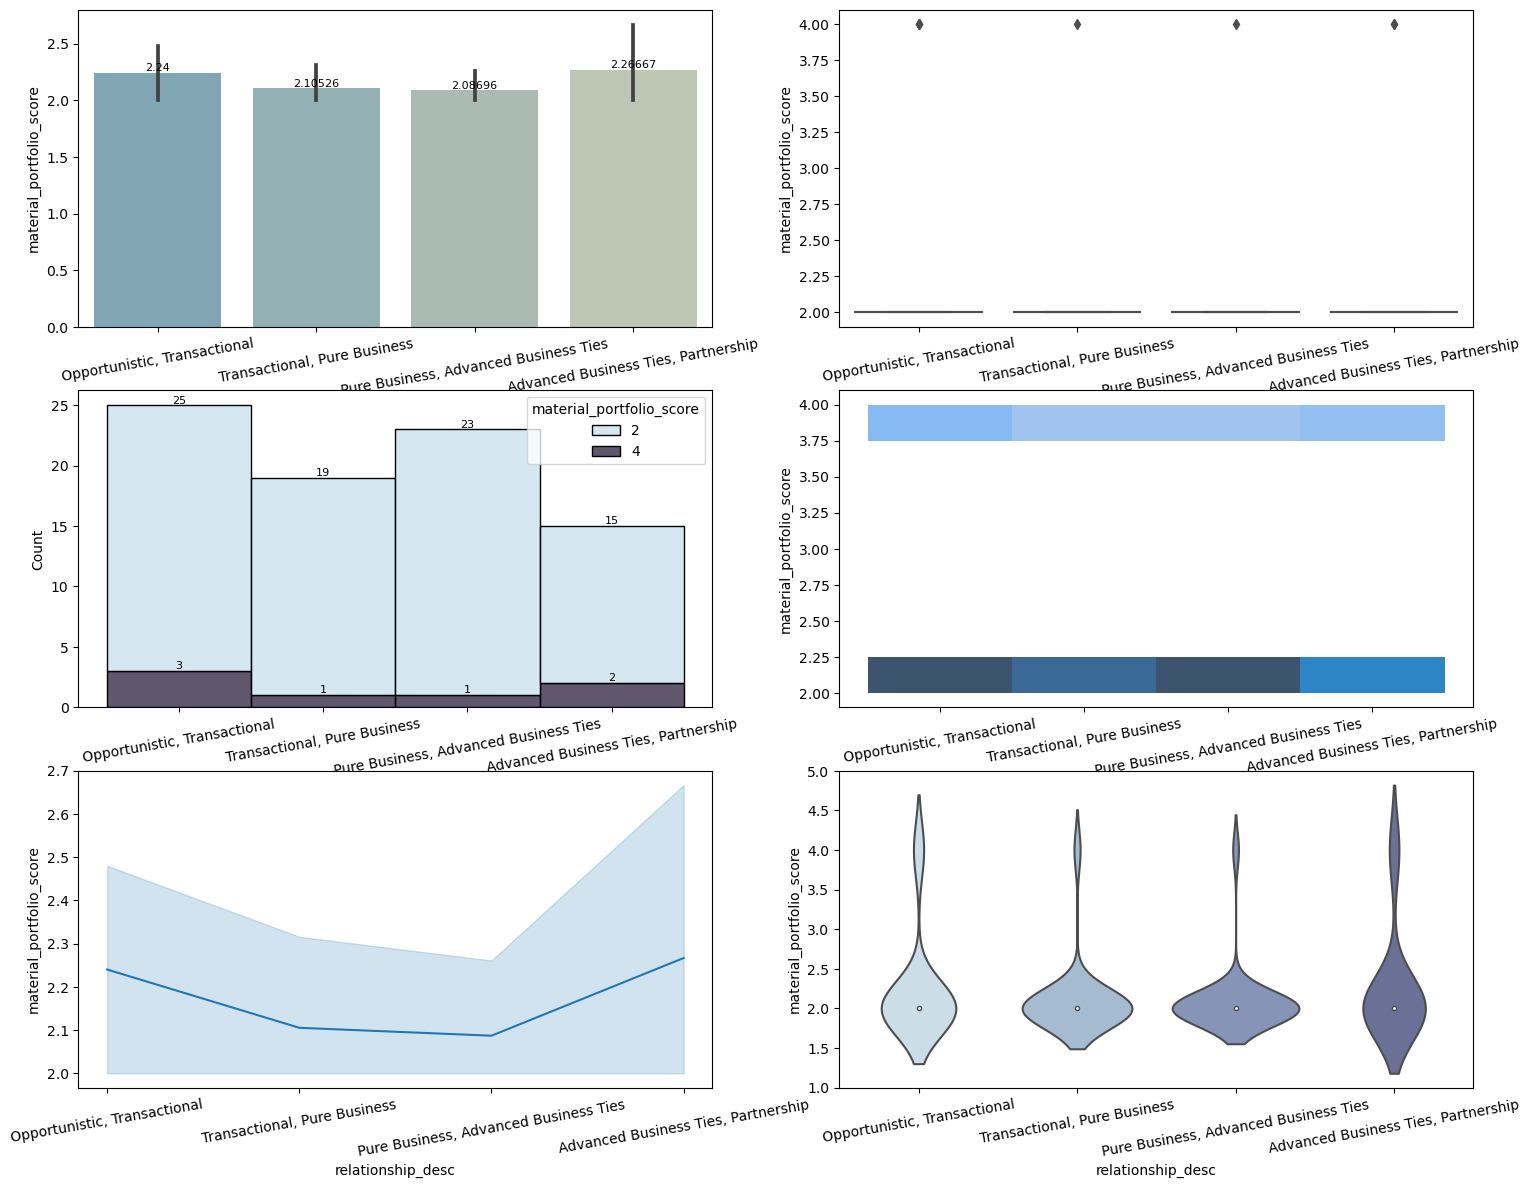

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  l = sns.lineplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_xticklabels(l.get_xticklabels(),rotation=label_rotation)


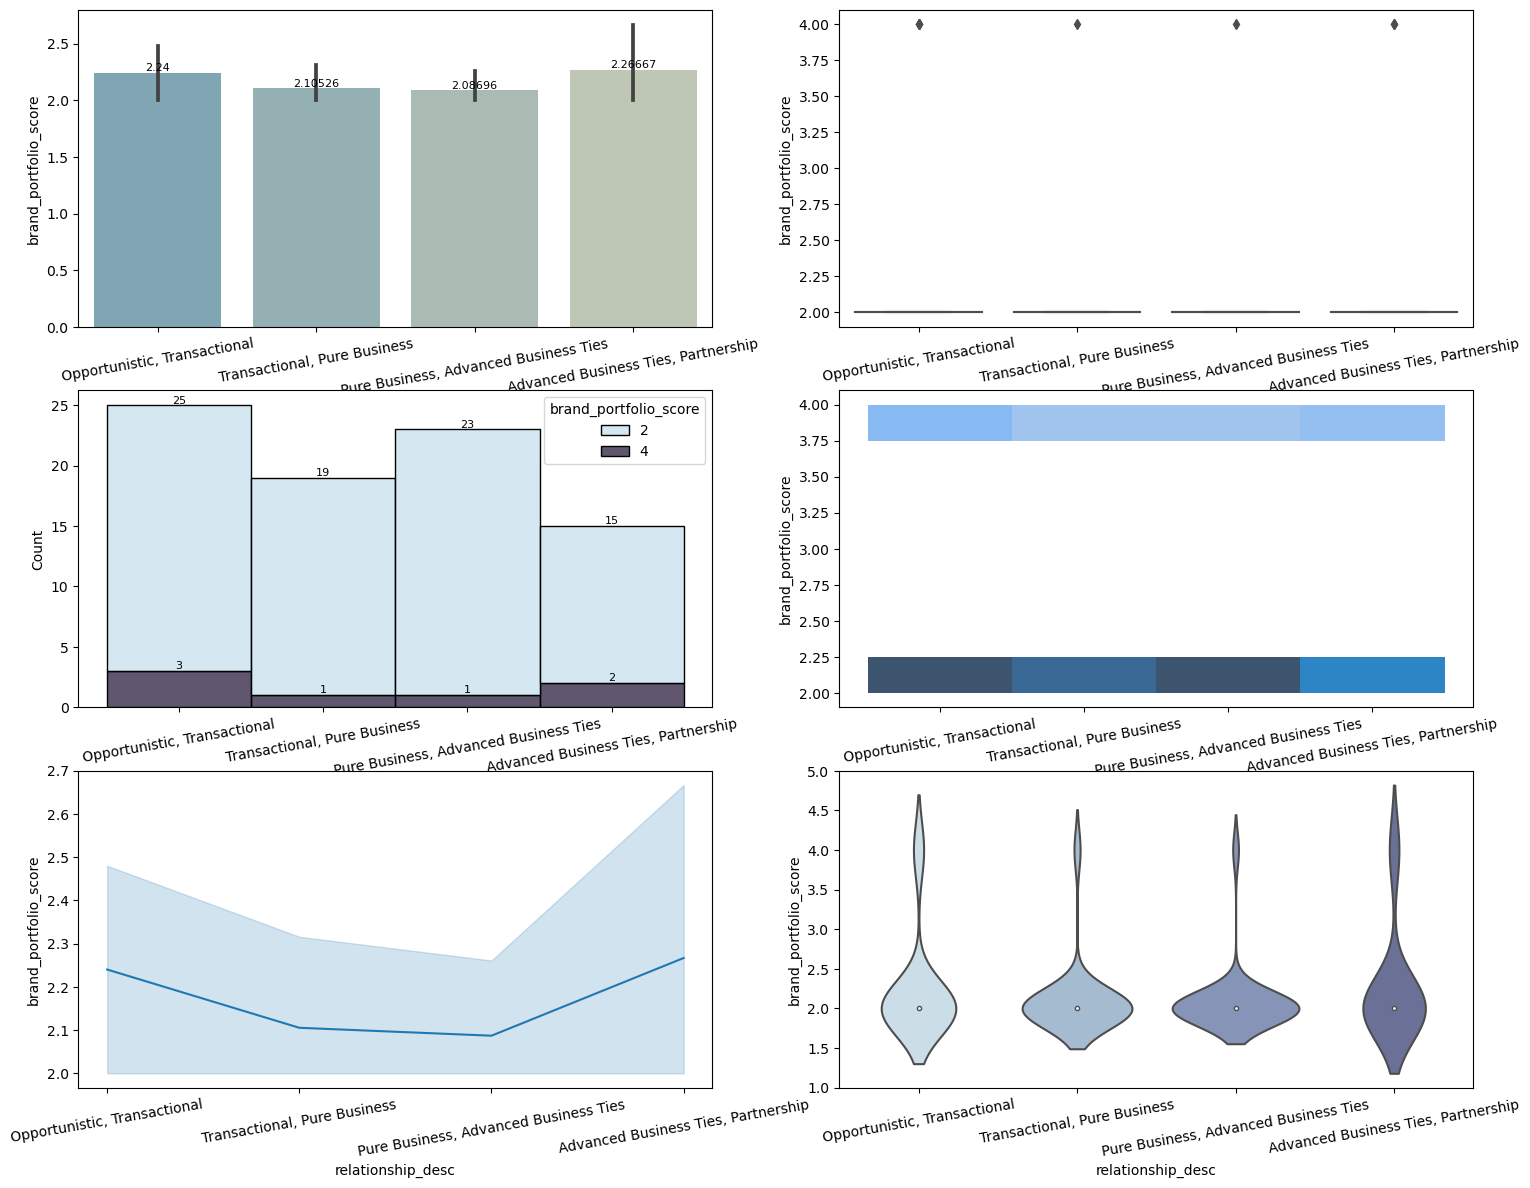

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  h1.set_xticklabels(h1.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  h2 = sns.histplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  h2.set_xticklabels(h2.get_xticklabels(),rotation=label_rotation)
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  l = sns.lineplot(
C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\2725016198.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_xticklabels(l.get_xticklabels(),rotation=label_rotation)


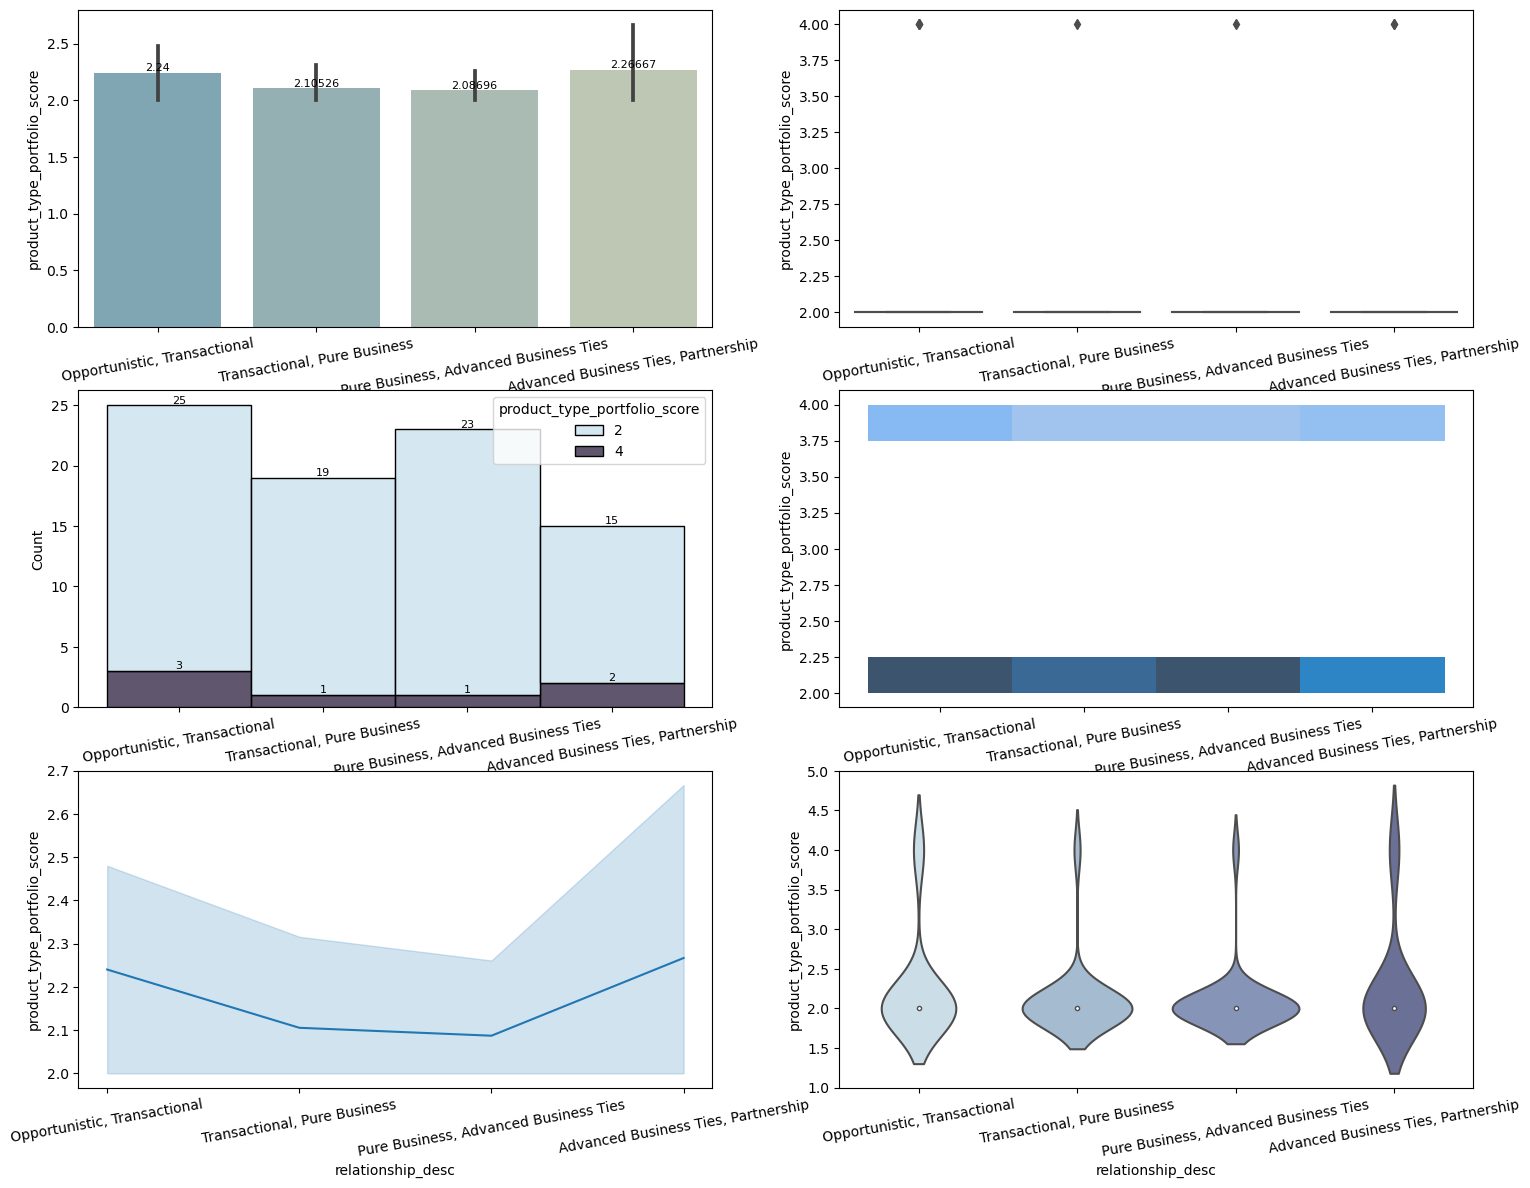

In [36]:
rel_tag_amb = ['Opportunistic, Transactional',
               'Transactional, Pure Business',
               'Pure Business, Advanced Business Ties',
               'Advanced Business Ties, Partnership']
for c in numcol_l:
    sea_figures(df      = df_select_data[df_select_data['relationship_desc'].isin(rel_tag_amb)].sort_values('relationship_score'),
                x_axis  = 'relationship_desc',
                y_axis  = c,
                figsize = (18,14))
    plt.show()

## Interactive figures
Plots made with a portion of data, adapted for streamlit deploy (dashboard)
* first n rows
* filtered data

grouped and particular data

Select customer
* materials
* window_tag
* plant_types (from where the material comes from)
* month_

In [37]:
df_select_data.columns

Index(['customer', 'sales_qty_2021', 'sales_qty_2022', 'sales_qty_2023',
       'sales_qty_2024', 'net_sales_2021', 'net_sales_2022', 'net_sales_2023',
       'net_sales_2024', 'p2_2021', 'p2_2022', 'p2_2023', 'p2_2024',
       'qty_2021_score', 'qty_2022_score', 'qty_2023_score', 'qty_2024_score',
       'sales_2021_score', 'sales_2022_score', 'sales_2023_score',
       'sales_2024_score', 'p2_2021_score', 'p2_2022_score', 'p2_2023_score',
       'p2_2024_score', 'qty_2021_score_desc', 'qty_2022_score_desc',
       'qty_2023_score_desc', 'qty_2024_score_desc', 'sales_2021_score_desc',
       'sales_2022_score_desc', 'sales_2023_score_desc',
       'sales_2024_score_desc', 'p2_2021_score_desc', 'p2_2022_score_desc',
       'p2_2023_score_desc', 'p2_2024_score_desc', 'market_position_score',
       'relationship_score', 'market_position_desc', 'relationship_desc',
       'material_portfolio', 'material_portfolio_desc', 'brand_portfolio',
       'brand_portfolio_desc', 'product_type_port

In [38]:
px.bar(df_select_data[df_select_data['relationship_desc'].isin(rel_tag)],
           x = 'market_position_score',
           y = 'relationship_score',
           color = 'qty_2023_score_desc',
           barmode = 'overlay',
           hover_name= 'customer',
           hover_data= ['material_portfolio_desc', 'brand_portfolio_desc', 'product_type_portfolio_desc', 'market_position_desc', 'relationship_desc'],
           opacity = .4
           )

In [39]:
px.scatter(df_select_data[df_select_data['relationship_desc'].isin(rel_tag)],
           x = 'market_position_score',
           y = 'relationship_score',
           color = 'qty_2023_score_desc',
           #barmode = 'overlay',
           hover_name= 'customer',
           hover_data= ['material_portfolio_desc', 'brand_portfolio_desc', 'product_type_portfolio_desc', 'market_position_desc', 'relationship_desc'],
           opacity = .4
           )

In [40]:
px.density_heatmap(df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
           x = 'relationship_desc',
           y = 'market_position_desc',
           #color = 'sales_2023_score_desc',
           #barmode = 'overlay',
           hover_name= 'customer',
           hover_data= ['material_portfolio_desc', 'brand_portfolio_desc', 'product_type_portfolio_desc', 'market_position_desc', 'relationship_desc'],
           #opacity = .4
           )

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\3560457930.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [41]:
px.density_heatmap(df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
           x = 'relationship_desc',
           y = 'sales_2024_score_desc',
           #color = 'sales_2023_score_desc',
           #barmode = 'overlay',
           hover_name= 'customer',
           hover_data= ['material_portfolio_desc', 'brand_portfolio_desc', 'product_type_portfolio_desc', 'market_position_desc', 'relationship_desc'],
           #opacity = .4
           )

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\298749905.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [42]:
px.density_heatmap(df_select_data[df_select_data['relationship_desc'].isin(rel_tag)][df_select_data['market_position_desc'].isin(mkt_tag)],
           x = 'market_position_desc',
           y = 'sales_2024_score_desc',
           #color = 'sales_2023_score_desc',
           #barmode = 'overlay',
           hover_name= 'customer',
           hover_data= ['material_portfolio_desc', 'brand_portfolio_desc', 'product_type_portfolio_desc', 'market_position_desc', 'relationship_desc'],
           #opacity = .4
           )

C:\Users\fefys\AppData\Local\Temp\ipykernel_9672\3335375087.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [43]:
# customer / month
month_cat = dict(zip(month_v, month_d))

# por un customer determinado elegido arbitrariamente (Customer_6863)
px.bar(df_numdata[df_numdata['customer'] == 'Customer_5537'][['customer', 'country','key_account', 'material', 'window_tag', 'plant_types', 'month_',
                                                               'sales_qty_2021','sales_qty_2022', 'sales_qty_2023', 'sales_qty_2024']].drop_duplicates().sort_values('window_tag', ascending=True),
        x = 'month_',
        y = ['sales_qty_2021','sales_qty_2022', 'sales_qty_2023', 'sales_qty_2024'],
        color = 'window_tag',
        hover_name = 'customer',
        hover_data = ['plant_types', 'country', 'material'],
        barmode = 'group',
        #category_orders = month_cat # no funciona siempre, mejor usar funcion update_xaxes
        )\
    .update_xaxes(categoryorder='array', categoryarray = month_d)

## Observaciones

Es posible considerar efectivamente que las calificaciones de volume importance(qty), ventas (sales), margen (p2) y portafolio (brand, material, product, feature_tag) puedan ayudar a reclasificar aquellos customers de prospectos para poder reorientar los esfuerzos de la empresa.

Se experimentara con modelos de clasificacion no supervisada para reclasificar en cuanto a relationship y mkt_pos para los casos de customers con multietiqueta.

In [44]:
print(f"customers con relationship definido: {len(df_select_data[df_select_data['relationship_desc'].isin(rel_tag)])} customer con mkt_pos definido: {len(df_select_data[df_select_data['market_position_desc'].isin(mkt_tag)])}")

customers con relationship definido: 336 customer con mkt_pos definido: 342


In [46]:
# dataframes ya guardados

#df_select_data.to_csv("omya/sources/preprocessed_data.csv", index=False)
#df_numdata.to_csv("omya/sources/numericdata.csv", index=False)
#df_p_cust.to_csv("omya/sources/categoricaldata.csv", index=False)

Next, 4_omya_clustering